In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

1) Построим кривые CLO rate
    - Выберем переменную для разбивки по бакетам
    - Проведем анализ поколений
    - Построим винтажи CLO rate
    - Проведем анализ на особые точки
    - Проведем анализ наличия внешних воздействий и при необходимости вычистим кривые
    - Построим среднее по винтажам для каждого бакета
    - Сгладим кривые
    
2) Построить кривые DEF rate
    - Пункты, аналогичные CLO rate


## Кривые CLO rate

#### Выгружаем данные с винтажами

In [4]:
df = pd.read_csv(
    'data/data_vintages.csv',
    sep=";",
    encoding="cp1251",
    index_col=0,
    date_format=lambda x: pd.to_datetime(x),
    parse_dates=['gen_month_dt', 'gen_quarter_dt']
)
df.head(10)

user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   
5    13089             14   2019-03-01     2019-01-01        0        0   
6   132017              7   2019-08-01     2019-07-01        1        0   
7    67966             24   2019-06-01     2019-04-01        1        0   
8   152759             11   2019-11-01     2019-10-01        0        0   
9   128462             20   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  
0        0        1             0             0             0             1  
1        0        0             1             0             0             0  
2        0        1             0             0             0             1  
3        0        1             0             0             0             1  
4        0        0             1             0             0             0  
5        0        1             0             0             0             1  
6        0        0             1             0             0             0  
7        0        0             1             0             0             0  
8        1        1             0             0             0             1  
9        0        0             1             0             0             0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2493268 entries, 0 to 2493267
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   statement_num   int64 
 2   gen_month_dt    object
 3   gen_quarter_dt  object
 4   clo_flg         int64 
 5   def_flg         int64 
 6   dlq_flg         int64 
 7   act_flg         int64 
 8   prev_clo_flg    int64 
 9   prev_def_flg    int64 
 10  prev_dlq_flg    int64 
 11  prev_act_flg    int64 
dtypes: int64(10), object(2)
memory usage: 247.3+ MB


In [6]:
df.gen_month_dt = pd.to_datetime(df.gen_month_dt)
df.gen_quarter_dt = pd.to_datetime(df.gen_quarter_dt)

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [8]:
df_scores = pd.read_csv(
    'data/data_scores.csv',
    sep=";",
    encoding="cp1251",
    decimal=',',
    index_col=0
)

df_scores.head(10)

user_id        pd   x_score
0     9311  0.035025  0.219980
1   155026  0.046279  0.146986
2    17584  0.007221  0.343298
3   156231  0.069679  0.186684
4   123587  0.010402  0.305582
5   125519  0.032667  0.261228
6   123890  0.027963  0.199389
7    82137  0.073694  0.113313
8    55227  0.011746  0.335474
9   124825  0.049237  0.227262

In [9]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104820 entries, 0 to 104819
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  104820 non-null  int64  
 1   pd       104820 non-null  float64
 2   x_score  104820 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 3.2 MB


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [11]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  \
0        0        1             0             0             0             1   
1        0        0             1             0             0             0   
2        0        1             0             0             0             1   
3        0        1             0             0             0             1   
4        0        0             1             0             0             0   

   pd_bucket  x_bucket        pd   x_score  
0          1         2  0.021296  0.469410  
1          2         0  0.064742  0.157215  
2          0         2  0.018490  0.469583  
3          1         1  0.025882  0.210896  
4          1         1  0.024330  0.269492

### Выберем переменную, которая делит кривые наилучшим образом

In [12]:
def plot_rate_by_bucket(df, bucket, type):
    type_flg = type + '_flg'
    prev_type_flg = 'prev_' + type + '_flg'
    return (df.groupby([bucket, "statement_num"])
            .agg({type_flg: 'sum', prev_type_flg: 'sum', "prev_act_flg": 'sum', "user_id": np.count_nonzero})\
            .rename(columns = ({type_flg: 'type_cnt', prev_type_flg: 'prev_type_cnt', "prev_act_flg": 'prev_act_cnt', "user_id": 'cnt'}))\
            .eval('rate = (type_cnt - prev_type_cnt) / prev_act_cnt', inplace=False)\
            .unstack(bucket)
            ['rate']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

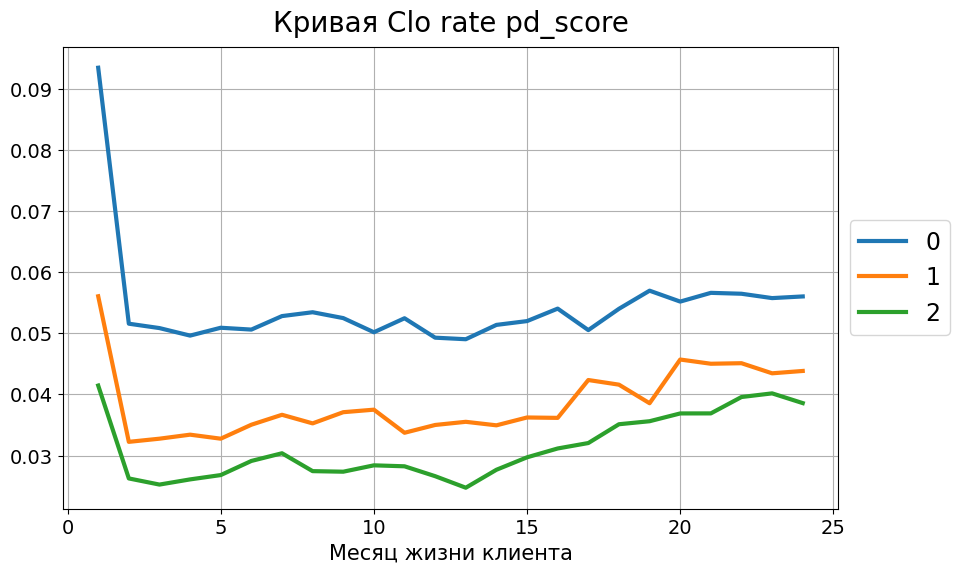

In [13]:
plot_rate_by_bucket(df, 'pd_bucket', 'clo')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate pd_score", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

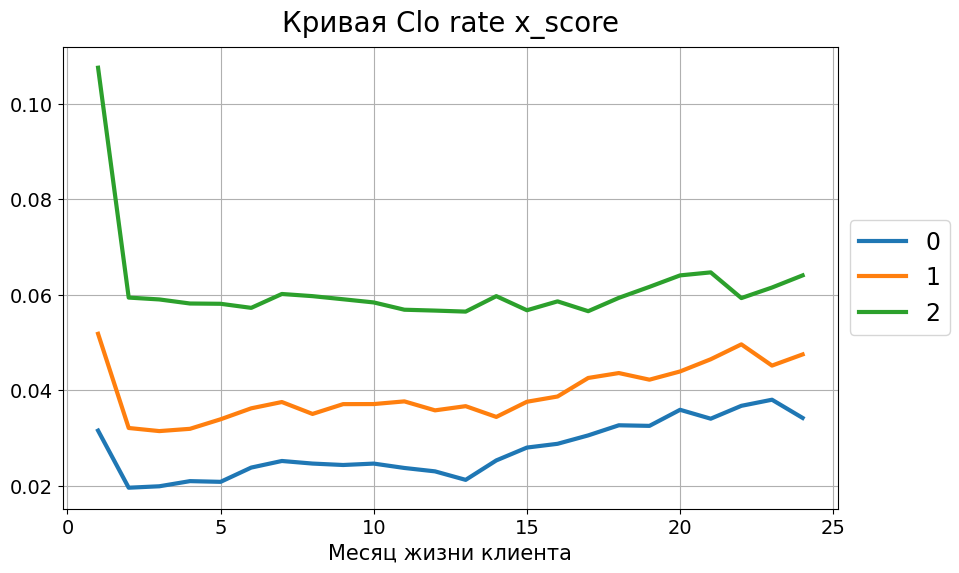

In [14]:
plot_rate_by_bucket(df, 'x_bucket', 'clo')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate x_score", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

По х_score кривые отстоят друг от друга дальше.

Поэтому будем смотреть в разрезе x_score.

### Анализ поколений

Отрисуем распределение данных во времени в разбивке по выбранной перменной

In [15]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0).T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

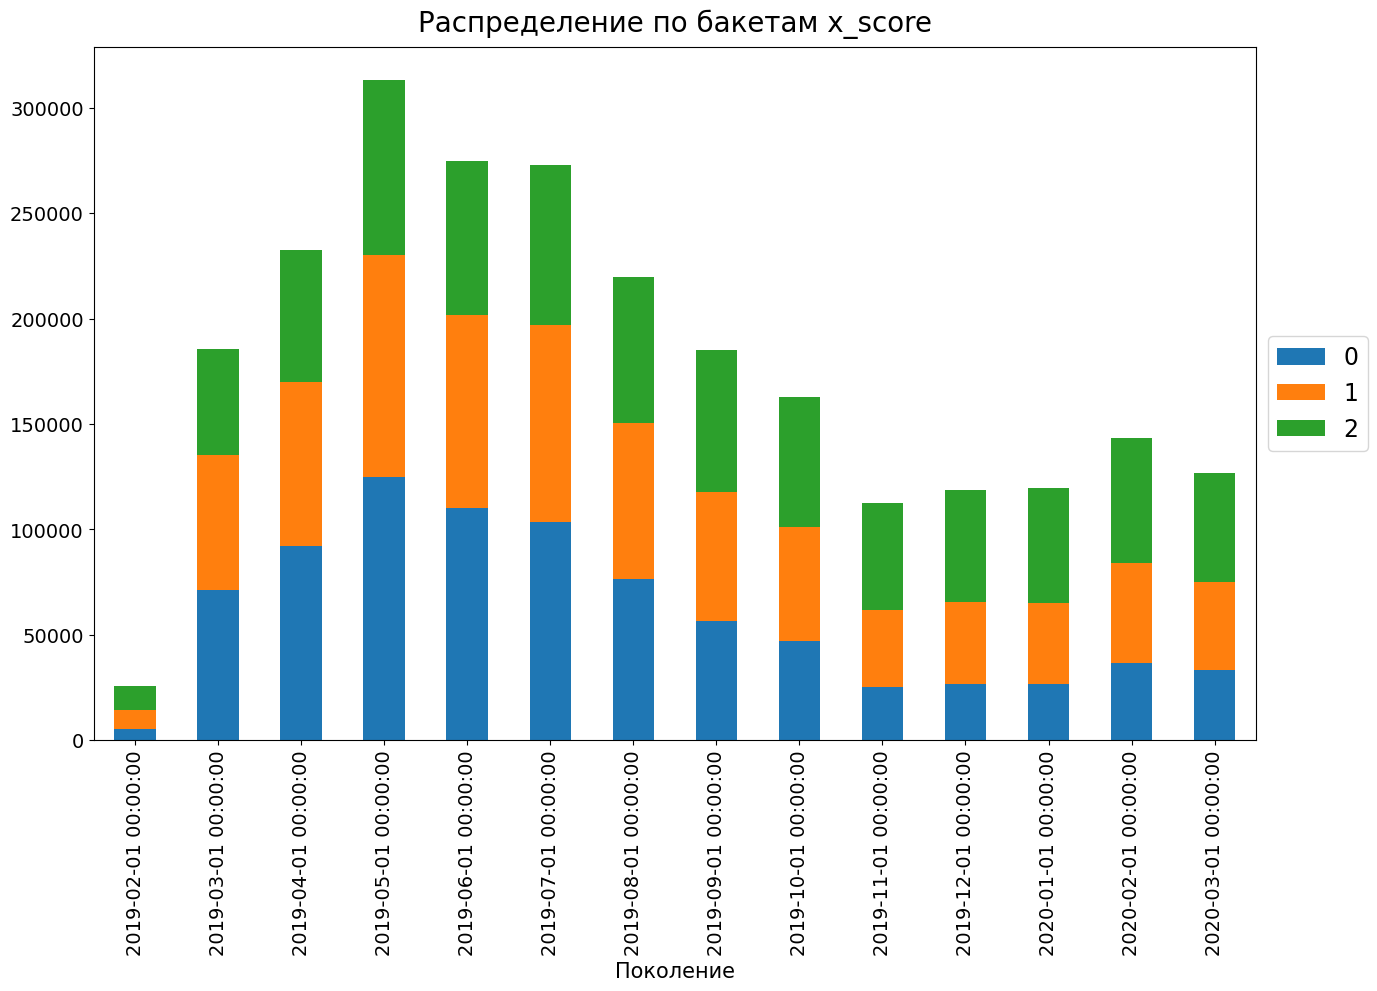

In [16]:
plot_distribution(df, 'x_bucket')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам x_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Однозначно исключаем февраль 19го, т.к в нем мало наблюдений.

In [17]:
df = df[df['gen_month_dt'] != '2019-02-01']

Есть смысл отбросить более старые поколения, но в данном случае мы рассматриваем всего 13 месяцев, а это не большой срок, поэтому я решила оставить все поколения.

### Кривые СLO Rate в разбивке по бакетам

Реализуем функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

In [18]:
# добавим стандартных цветов, чтобы различать все 13 винтажей на графиках.
custom_colors = [
    '#0000FF',  # Blue
    '#FFA500',  # Orange
    '#008000',  # Green
    '#FF0000',  # Red
    '#FFFF00',  # Yellow
    '#4B0082',  # Indigo
    '#EE82EE',  # Violet
    '#FFC0CB',  # Pink
    '#808080',  # Gray
    '#000000',  # Black
    '#808000',  # Olive
    '#00FFFF',  # Cyan
    '#FF00FF',  # Magenta
]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

In [19]:
def plot_rate_by_generation(df, type):
    type_flg = type + '_flg'
    prev_type_flg = 'prev_' + type + '_flg'
    return (df.groupby(["gen_month_dt", "statement_num"])
            .agg({type_flg: 'sum', prev_type_flg: 'sum', "prev_act_flg": 'sum', "user_id": np.count_nonzero})\
            .rename(columns = ({type_flg: 'type_cnt', prev_type_flg: 'prev_type_cnt', "prev_act_flg": 'prev_act_cnt', "user_id": 'cnt'}))\
            .eval('rate = (type_cnt - prev_type_cnt) / prev_act_cnt', inplace=False)\
            .unstack('gen_month_dt')
            ['rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

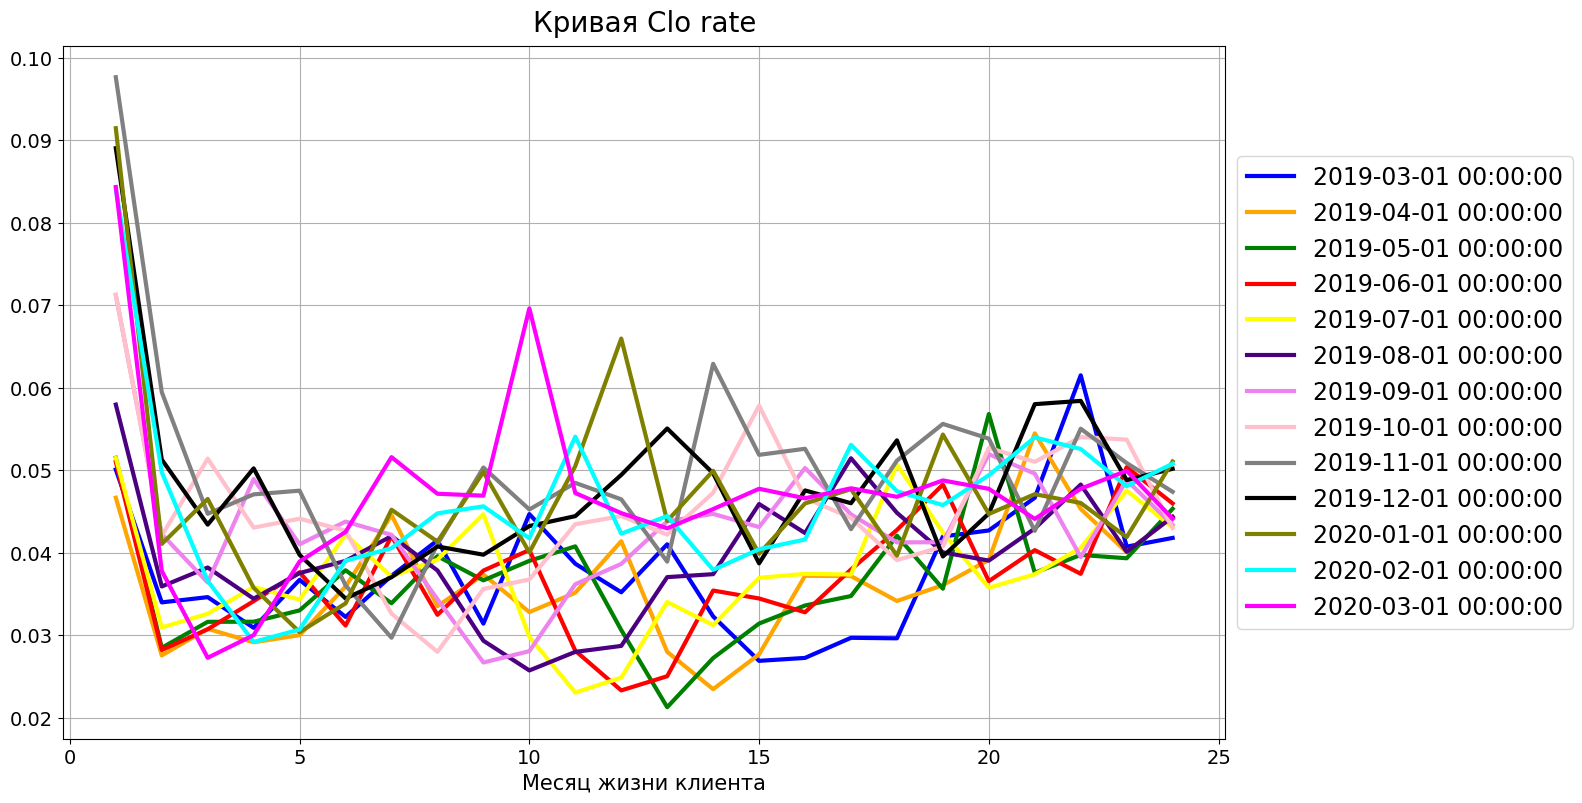

In [20]:
plot_rate_by_generation(df, 'clo')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Особые точки

Особая точка в 1 месяц: скорее всего, люди берут кредит на какие-то срочные нужды, но через месяц у них появляются деньги и они возвращают их в банк, либо у них меняется ситуация и они понимают, что эти деньги им уже не нужны. Исключать не нужно, т.к. такая ситуация повторяется на всех кривых.

Особые точки января 21 года: скорее всего, выбросы.

Пока вижу закономерность, что, если особая точка наблюдается именно в какой-то конкретный месяц жизни клиента, то это объясняется повторяющимся поведением клиентов, а если особые точки выпадают на какую-то конкретную мировую дату, то это будет обуславливаться влиянием внешних воздействий.

### Макроэкономические воздействие

In [21]:
buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)
buckets

1    0
3    1
0    2
Name: x_bucket, dtype: int64

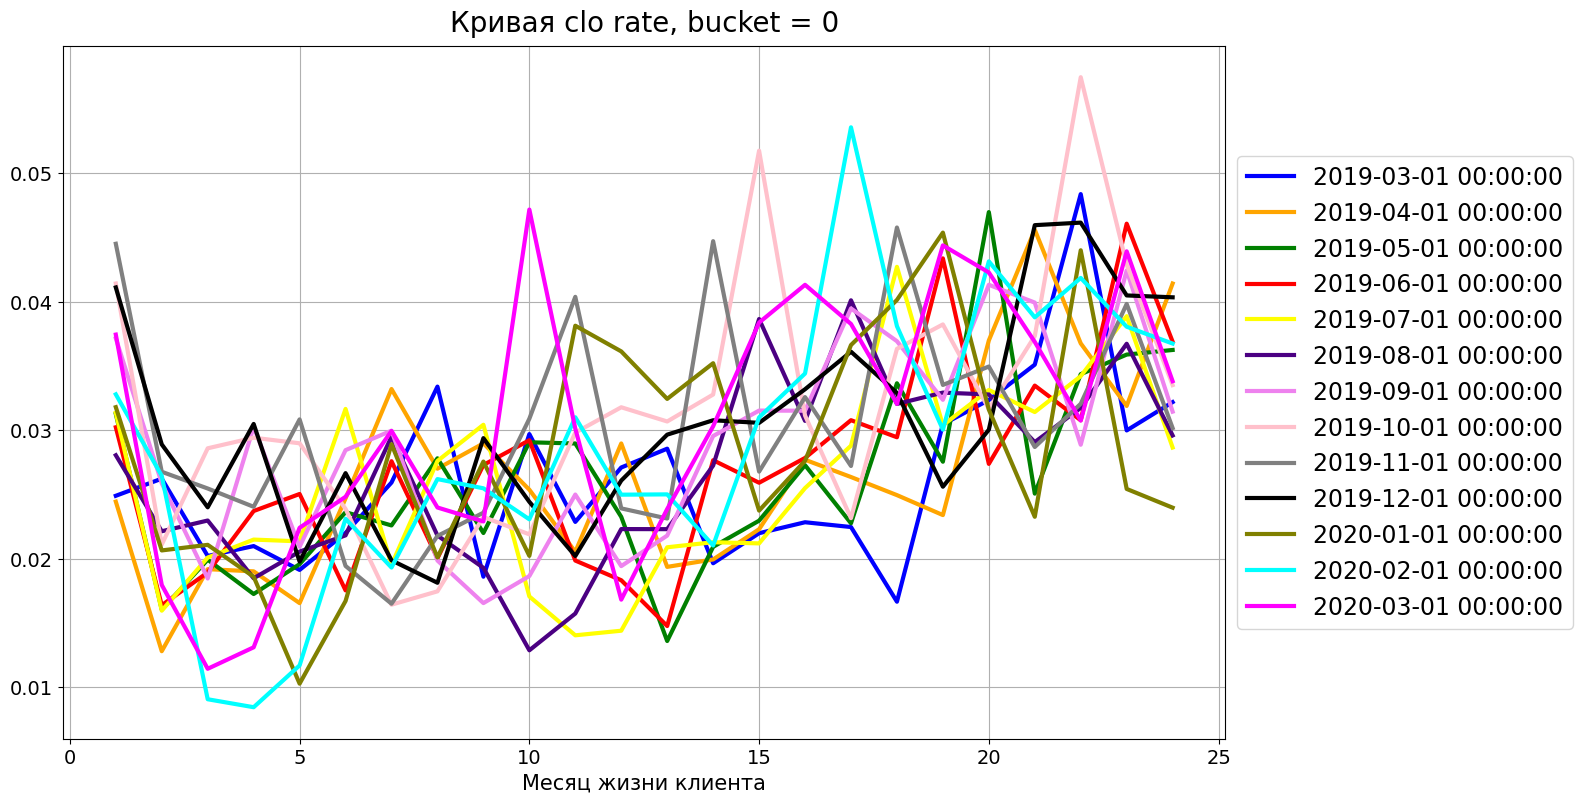

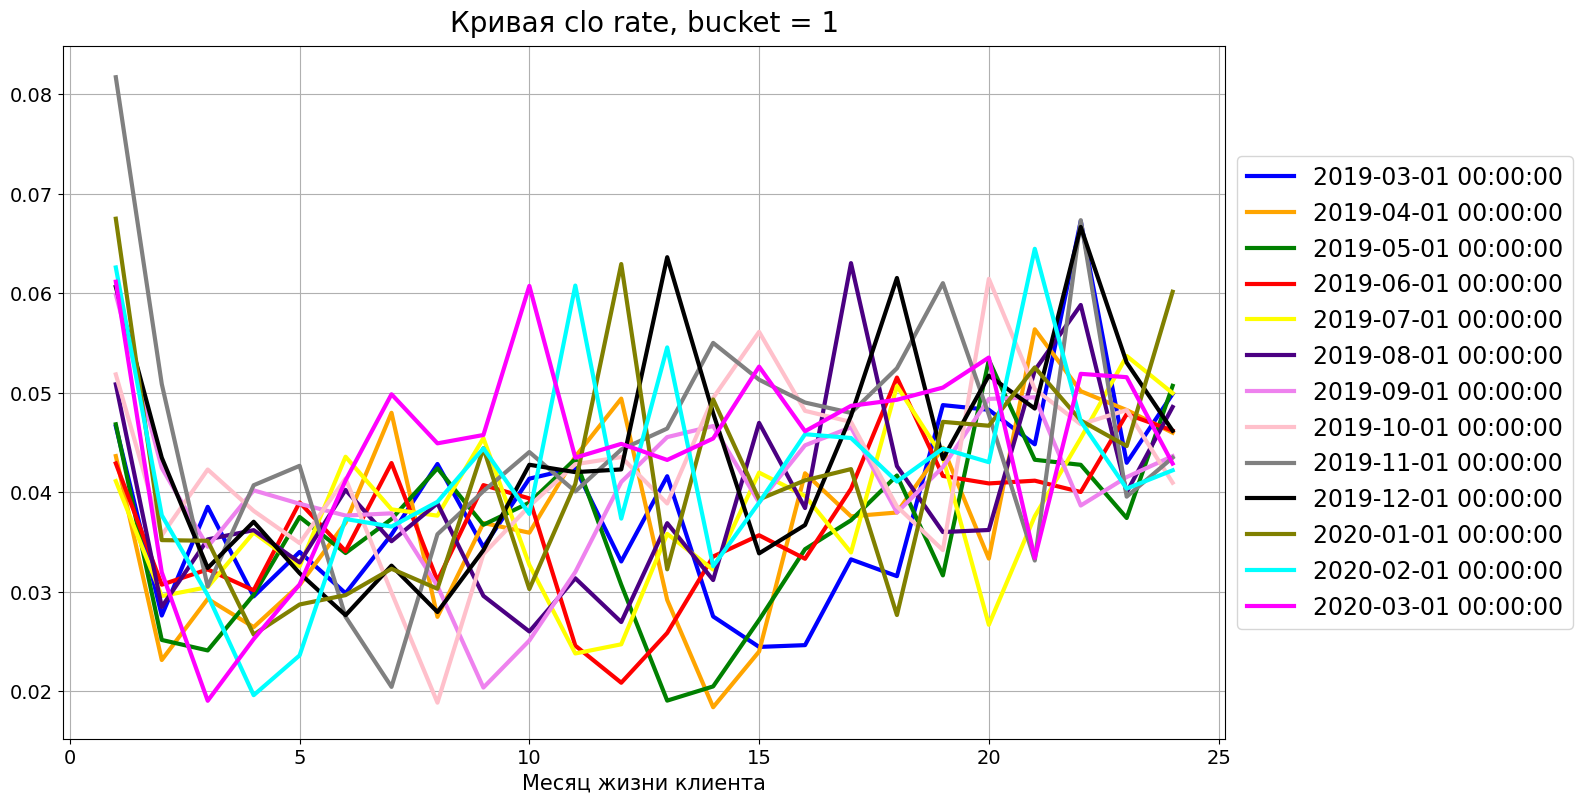

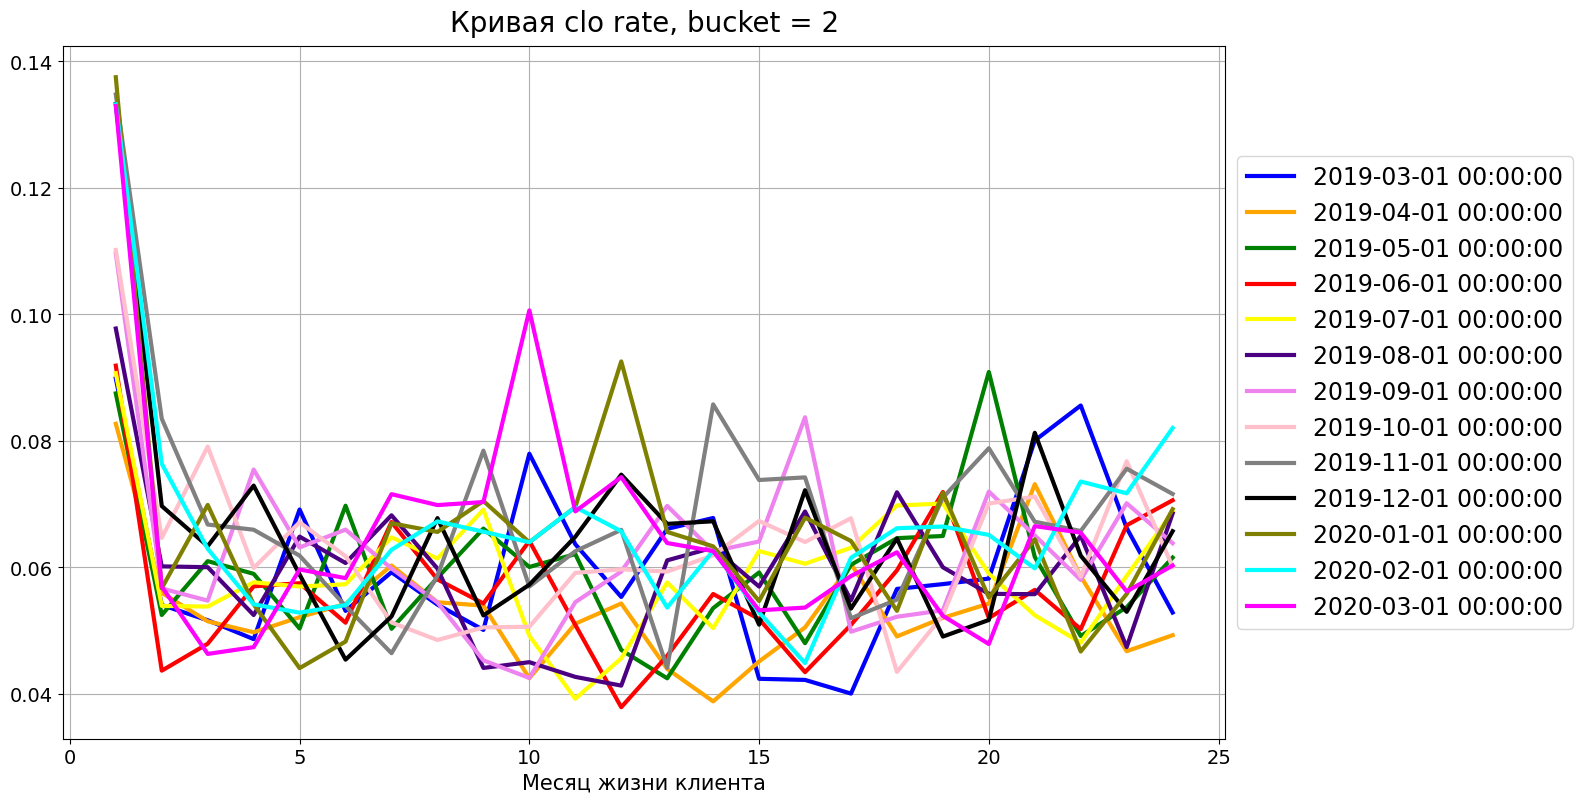

In [22]:
def plot_rate_by_bucket_generation(data, bucket_type, bucket, type):
    type_flg = type + '_flg'
    prev_type_flg = 'prev_' + type + '_flg'
    q = f'{bucket_type} == {bucket}'
    data_tmp = data.query(q)\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({type_flg: 'sum', prev_type_flg: 'sum', "prev_act_flg": 'sum', "user_id":np.count_nonzero})\
        .rename(columns = ({type_flg: 'type_cnt', prev_type_flg: 'prev_type_cnt', "prev_act_flg": 'prev_act_cnt', "user_id":"cnt"}))\
        .eval('rate = (type_cnt - prev_type_cnt) / prev_act_cnt', inplace=False)\
        .unstack('gen_month_dt')['rate']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title(f"Кривая {type} rate, bucket = " + str(bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
for i in buckets:
    plot_rate_by_bucket_generation(df, 'x_bucket', i, 'clo')

На этих графиках видны пики, которые появляются в январь 21 года.

In [23]:
def curve_build(data, 
                feature, 
                generation = 'generation_quart',
                statement_num = 'statement_num', 
                group_label = '1'):
    
    """Вспомогательная функция для построения разложения в рамках одного бакета
    
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов 
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])
    
    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1 

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0 
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([10**(-5) for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)], 
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице. 
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean
    
    # И умножаем на полученный коэффициент кривые созревания
    
    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    # fix
    df_query.month_dt = pd.to_datetime(df_query.month_dt)
    
    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)
    
    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

In [24]:
# Подготавливаем данные
df_rate = df.groupby(["x_bucket", "gen_month_dt", "statement_num"], as_index=False)\
        .agg({"clo_flg": 'sum', "prev_clo_flg": 'sum', "prev_act_flg": 'sum', "user_id": np.count_nonzero})\
        .rename(columns = ({"clo_flg": 'clo_cnt', "prev_clo_flg": 'prev_clo_cnt', "prev_act_flg": 'prev_act_cnt', "user_id": 'cnt'}))\
        .eval('clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt', inplace=False)


# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых 
res = decomposition(df_rate, 
                       generation = 'gen_month_dt', 
                       group = 'x_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'clo_rate')

C:\Users\pc\AppData\Local\Temp\ipykernel_12784\2965199190.py:127: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query['month_dt'] = df_query[generation] + timedelta


x_bucket = 0
Initial 0.272580
0  0.106623
1  0.106400
2  0.106385
3  0.106380
4  0.106378
5  0.106376
6  0.106376
7  0.106375
8  0.106375
9  0.106375
x_bucket = 1
Initial 0.542695
10  0.179471
11  0.178722
12  0.178627
13  0.178586
14  0.178565
15  0.178554
16  0.178548
17  0.178545
18  0.178544
19  0.178543
20  0.178542
21  0.178542
22  0.178542
x_bucket = 2
Initial 1.262871
23  0.321032
24  0.313800
25  0.312072
26  0.311250
27  0.310823
28  0.310601
29  0.310484
30  0.310423
31  0.310391
32  0.310374
33  0.310365
34  0.310360
35  0.310358
36  0.310357
37  0.310356
38  0.310356
39  0.310355


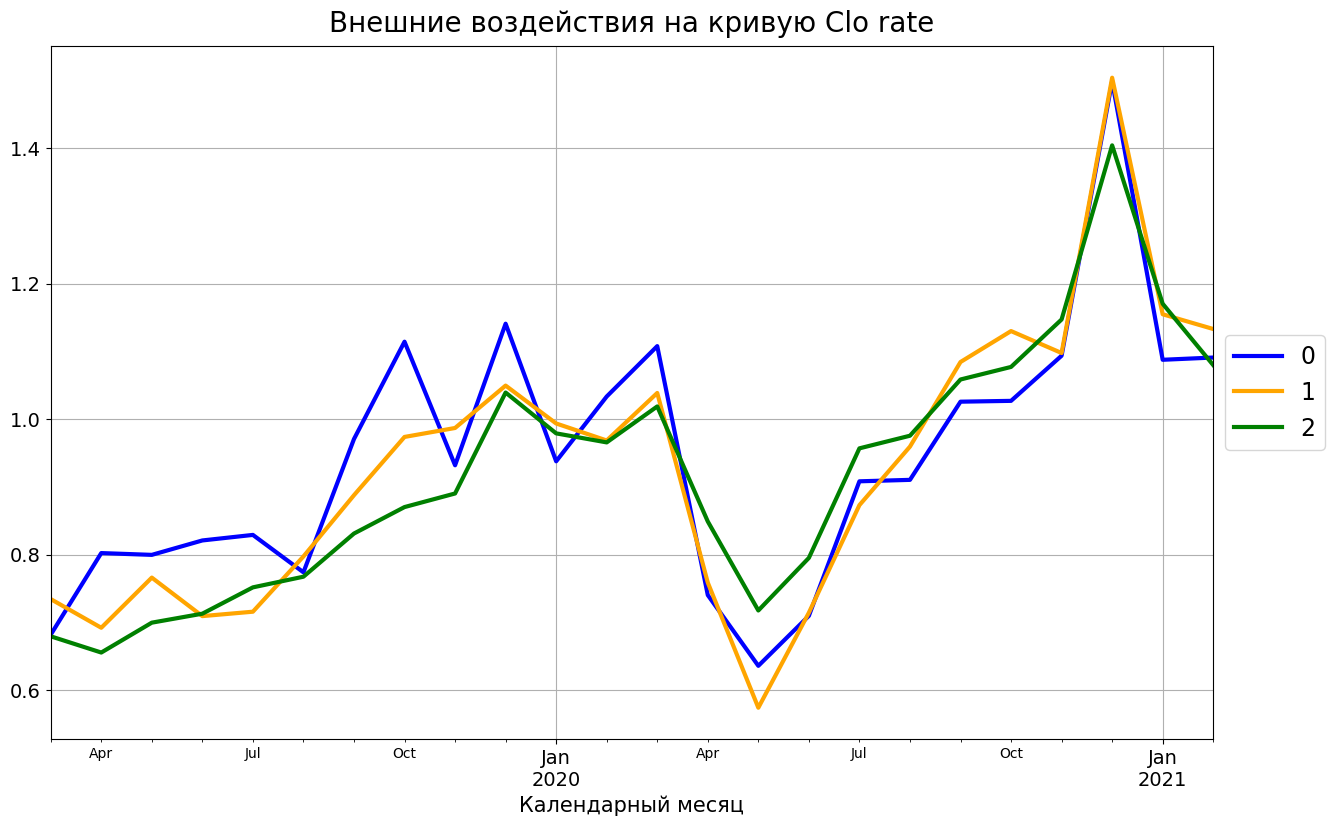

In [25]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Явно видно большое влияние внешнего воздействия в декабре 2020 года.

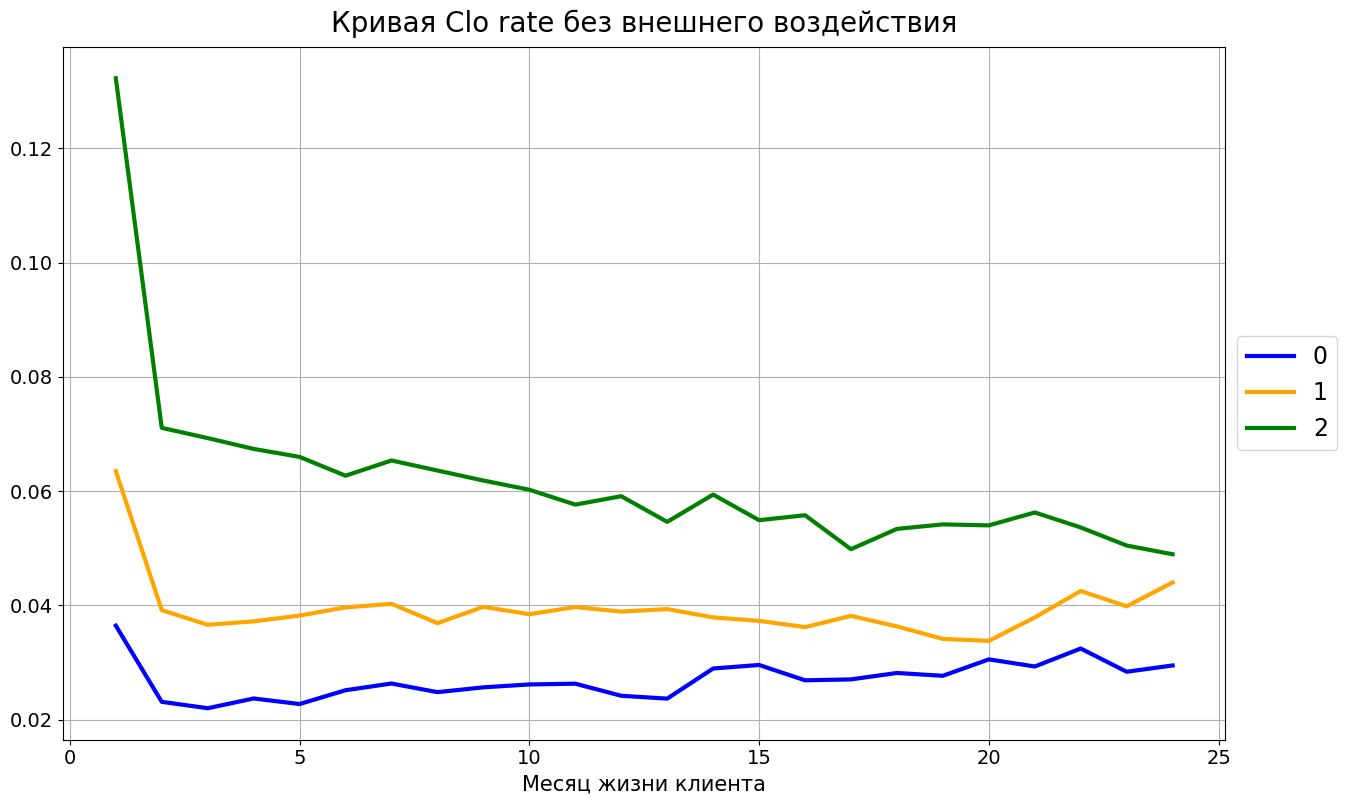

In [26]:
res['maturation_data'].drop(['statement_num'], axis=1).set_axis(range(1, 24+1)).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate без внешнего воздействия", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Среднее по бакетам

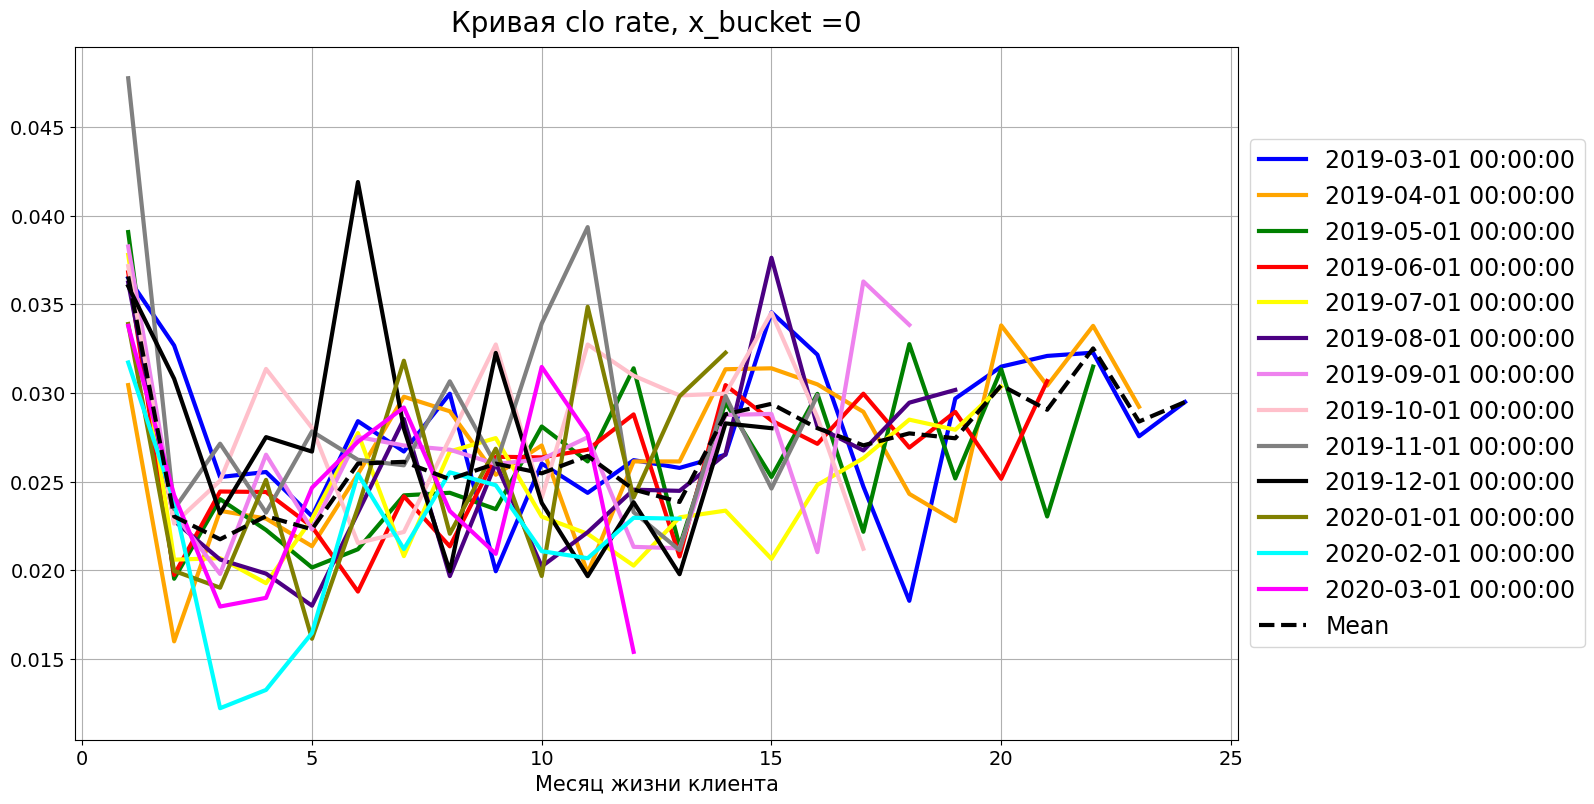

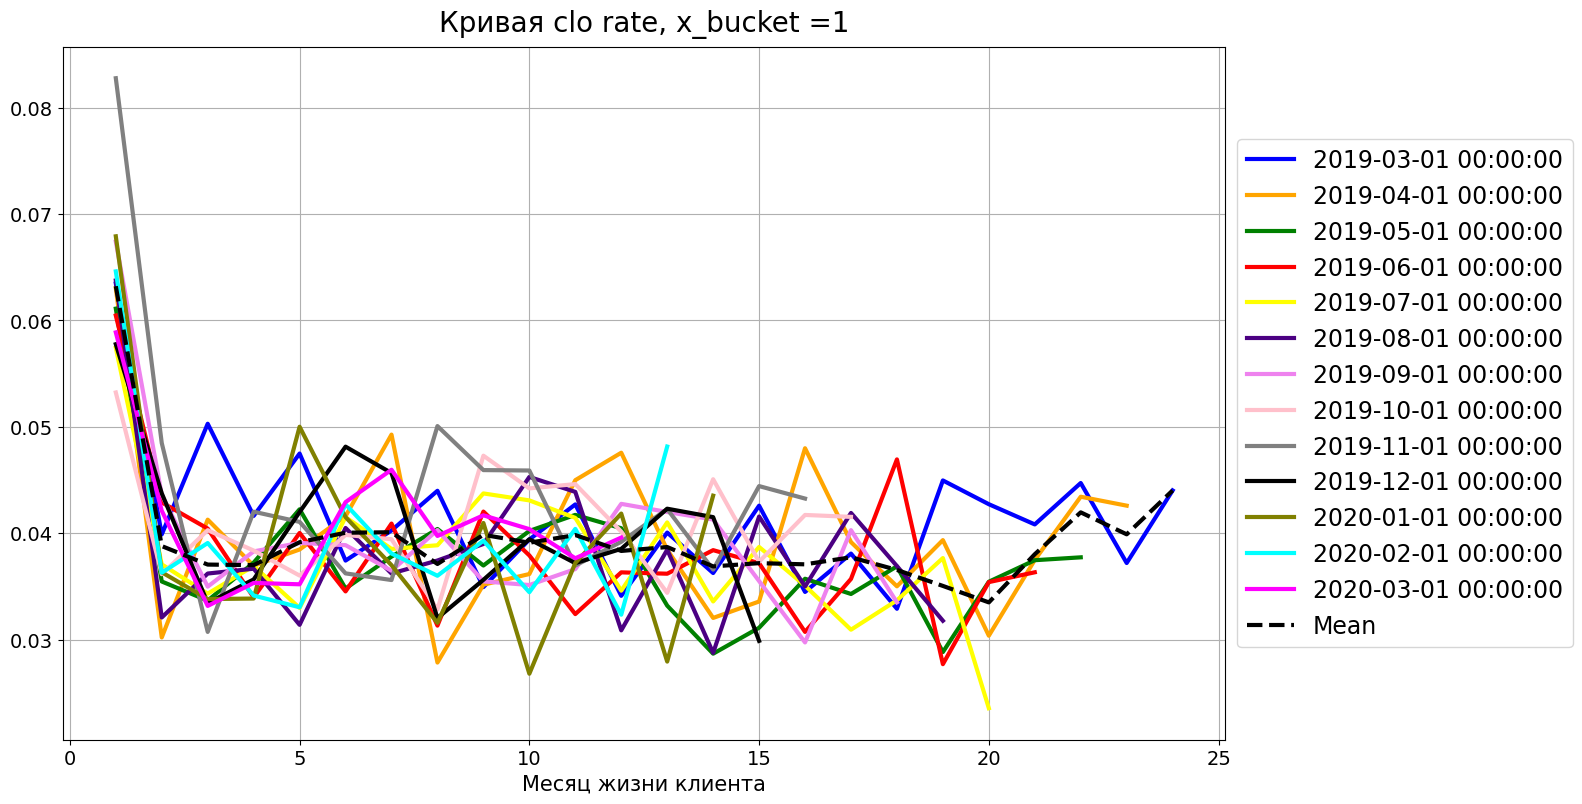

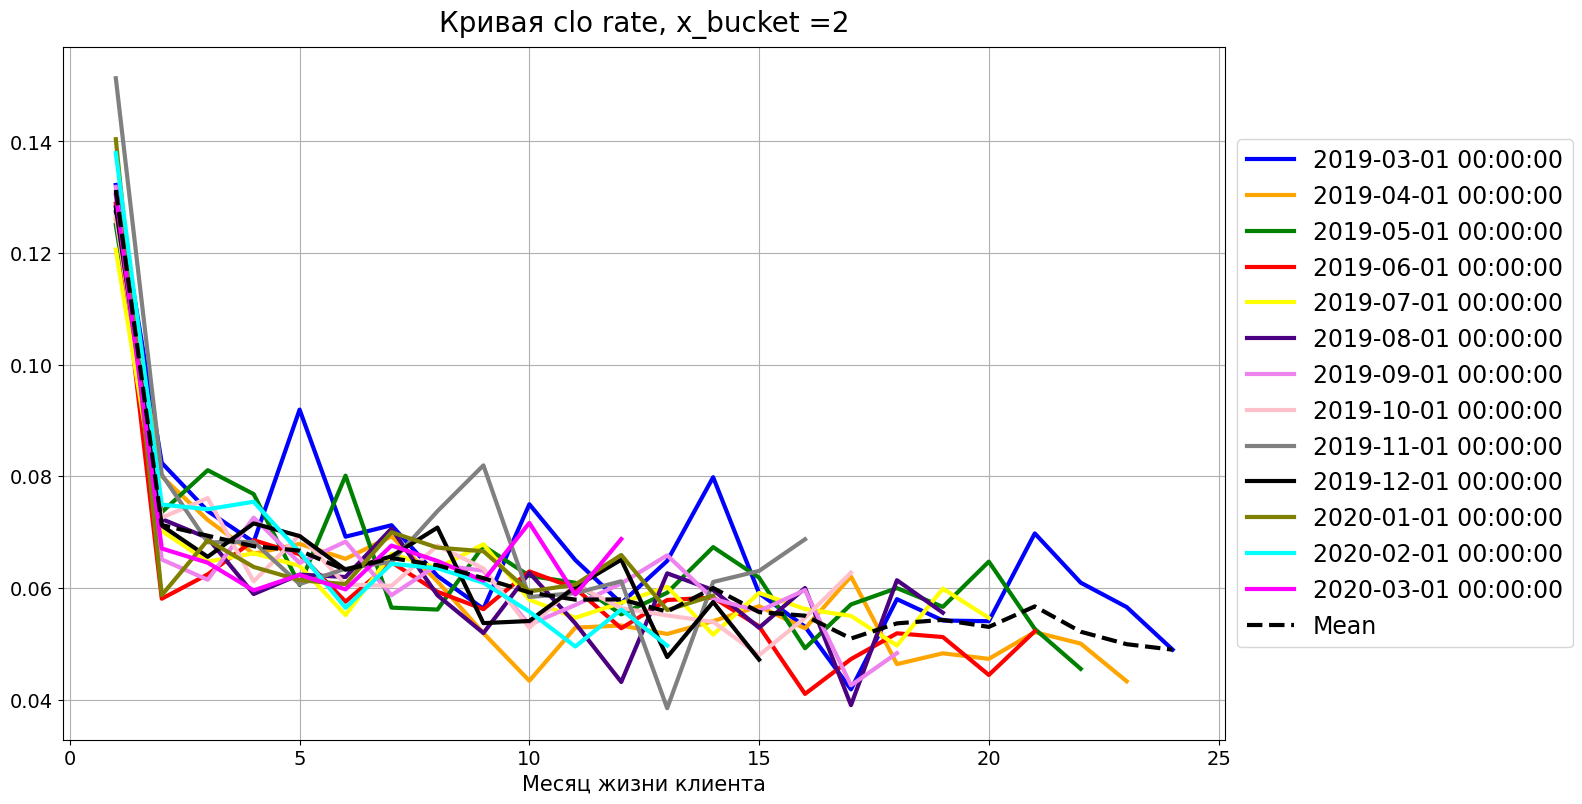

In [27]:
rate_mean = res['fitted_data'].groupby(['x_bucket', 'statement_num']).agg({'fitted_feature': 'mean'}).rename(columns = {'fitted_feature': 'Mean'})  

buckets = df['x_bucket'].drop_duplicates()

def plot_rate_mean(bucket_type, bucket, type):
    vintages_graph = res['fitted_data'].query(f'{bucket_type} == ' + str(bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature": 'sum'})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (rate_mean.query(f'{bucket_type} == ' + str(bucket))['Mean'].reset_index(drop=True).set_axis(range(1, 24+1))
             .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title(f"Кривая {type} rate, {bucket_type} =" + str(bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in sorted(buckets):
    plot_rate_mean('x_bucket', i, 'clo')

В целом, размах значений получился стабилен почти везде на всех 3 бакетах. В некоторых местах присутствуют выбросы.

### Сглаживание средних кривых

In [28]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Mean']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Mean'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Mean']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Mean'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Mean'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Mean'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Mean'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

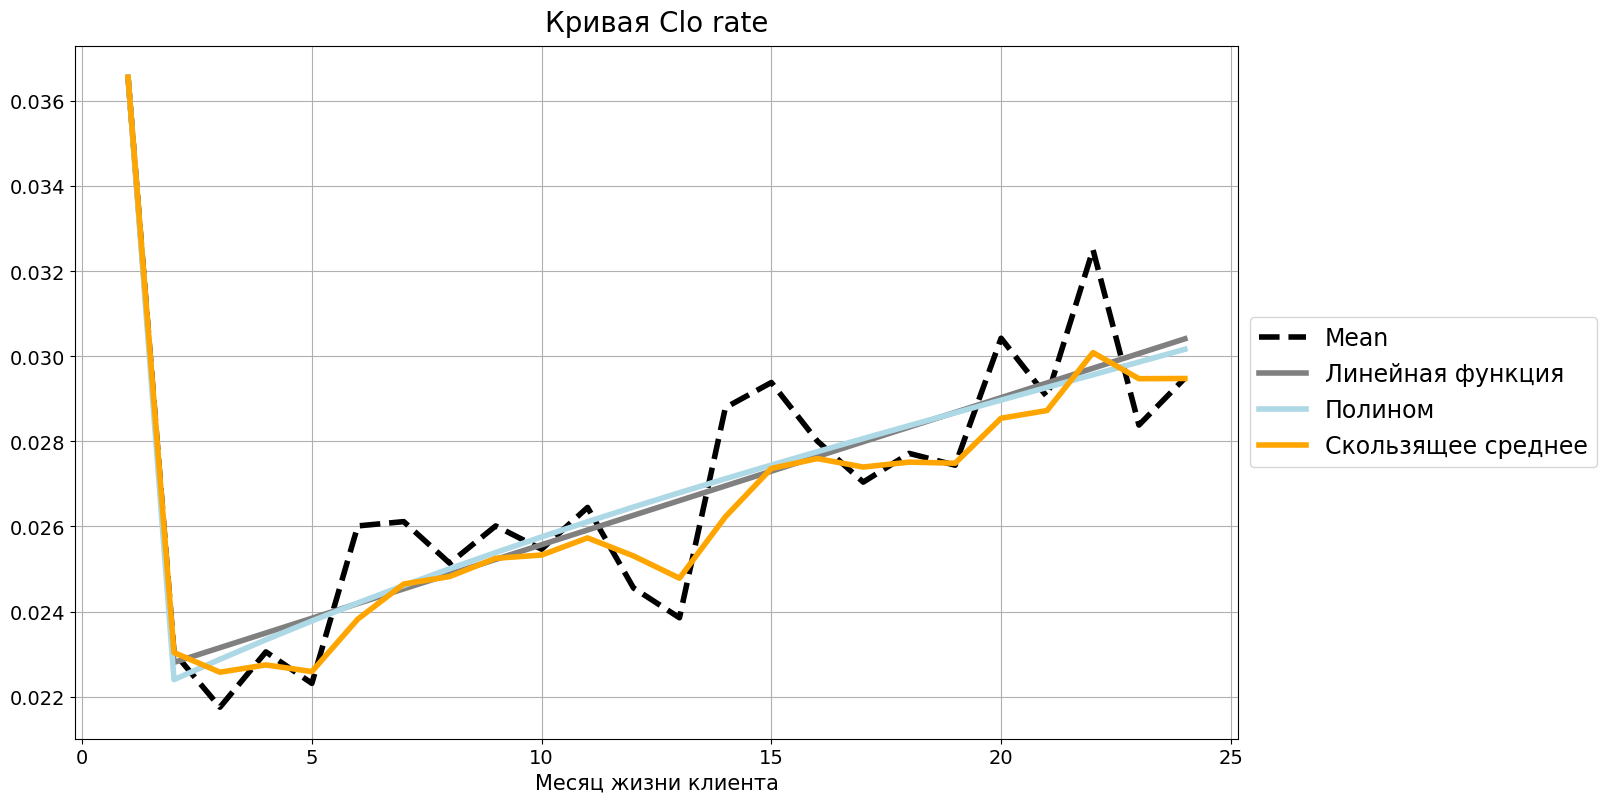

In [29]:
df_linear = rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 2, 24)
df_polynom = polynom_approximation(df_linear, 2, 24, 3)
df_smooth = exponential_smoothing(df_polynom, 2, 24, 0.36)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Mean'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Скользящее среднее в зависимости от параметра либо лежит выше/ниже среднего, либо слишком фиттится.
Линейная функция плохо описывает сложные зависимости, а здесь такие присутствуют.
Полином подошел лучше всего.

К первому месяцу я не применила сглаживание, т.к., исходя из винтажей, ситуация, что я описывала выше, будет повторяться для всех поколений.

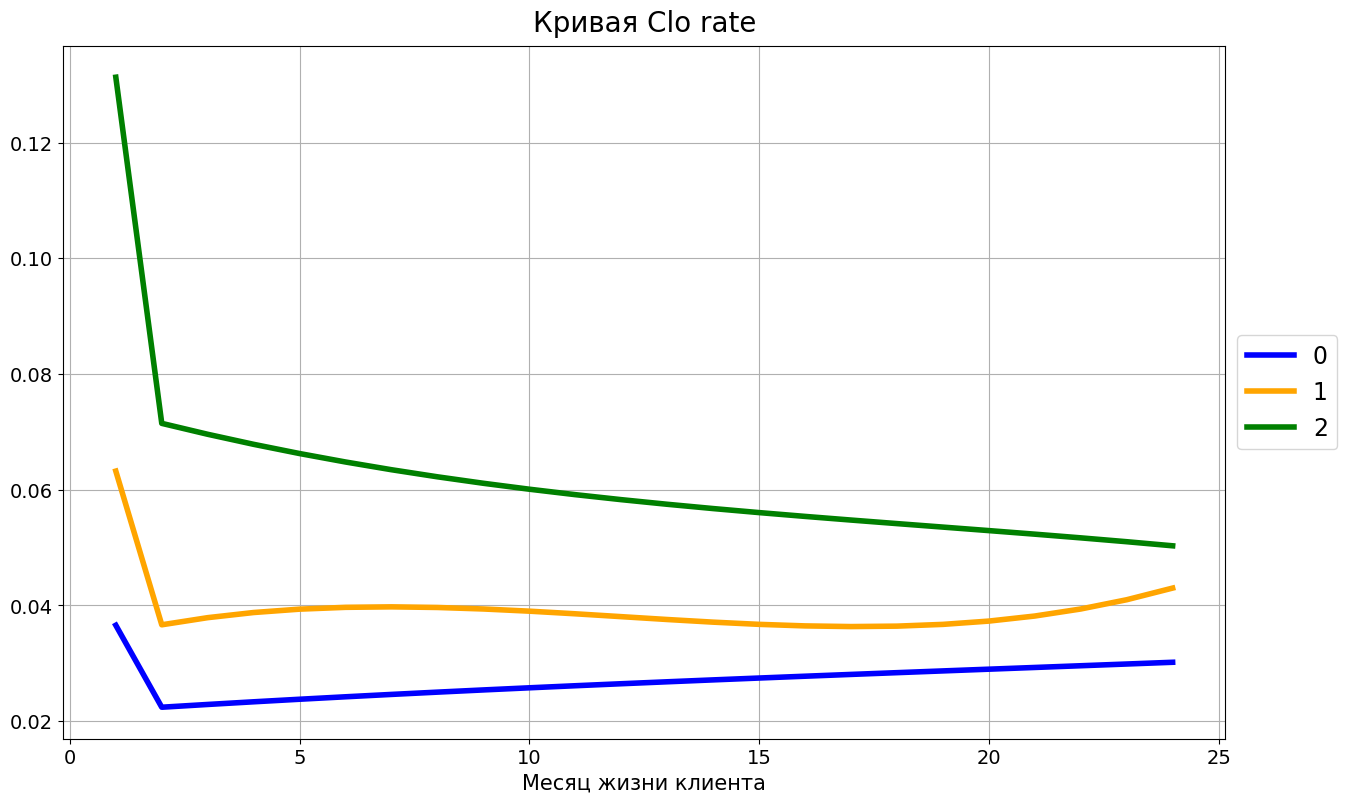

In [32]:
df_linear_0 = rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_polynom_0 = polynom_approximation(df_linear_0, 2, 24, 3)

df_linear_1 = rate_mean.query('x_bucket == 1').reset_index().set_index(['statement_num'])
df_polynom_1 = polynom_approximation(df_linear_1, 2, 24, 3)

df_linear_2 = rate_mean.query('x_bucket == 2').reset_index().set_index(['statement_num'])
df_polynom_2 = polynom_approximation(df_linear_2, 2, 24, 3)


plt.figure(figsize=(15, 9))
df_polynom_0['Полином'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
df_polynom_1['Полином'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)
df_polynom_2['Полином'].plot(grid=True, color = 'Green', linestyle = '-', lw = 4)


plt.legend(range(3), loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [47]:
df_smooth_result = pd.DataFrame(df_polynom_0['Полином']).rename({'Полином': 'pa = 0.133270'}, axis='columns')
df_smooth_result['pa = 0.220838'] = df_polynom_1['Полином']
df_smooth_result['pa = 0.379452'] = df_polynom_2['Полином']

In [49]:
df_smooth_result.to_csv('data/clo_rate.csv')

## Теперь проделаем все то же самое для DEF Rate

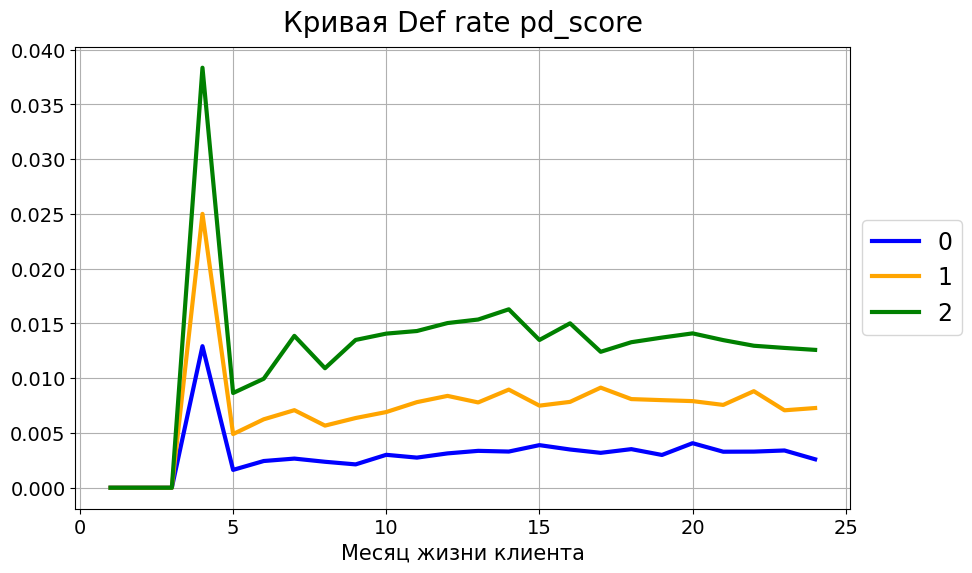

In [50]:
plot_rate_by_bucket(df, 'pd_bucket', 'def')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Def rate pd_score", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

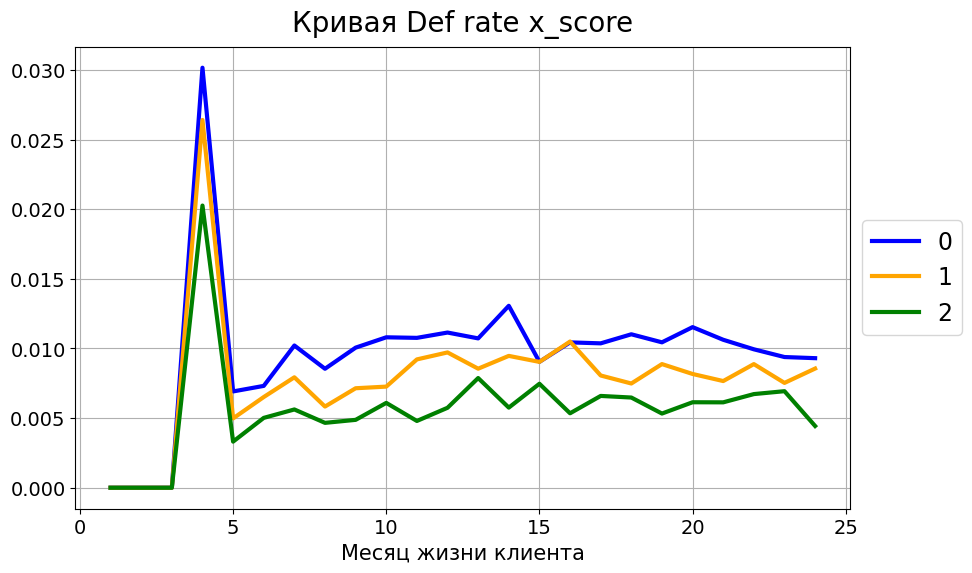

In [51]:
plot_rate_by_bucket(df, 'x_bucket', 'def')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Def rate x_score", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В случае def rate pd_score лучше делит кривые.

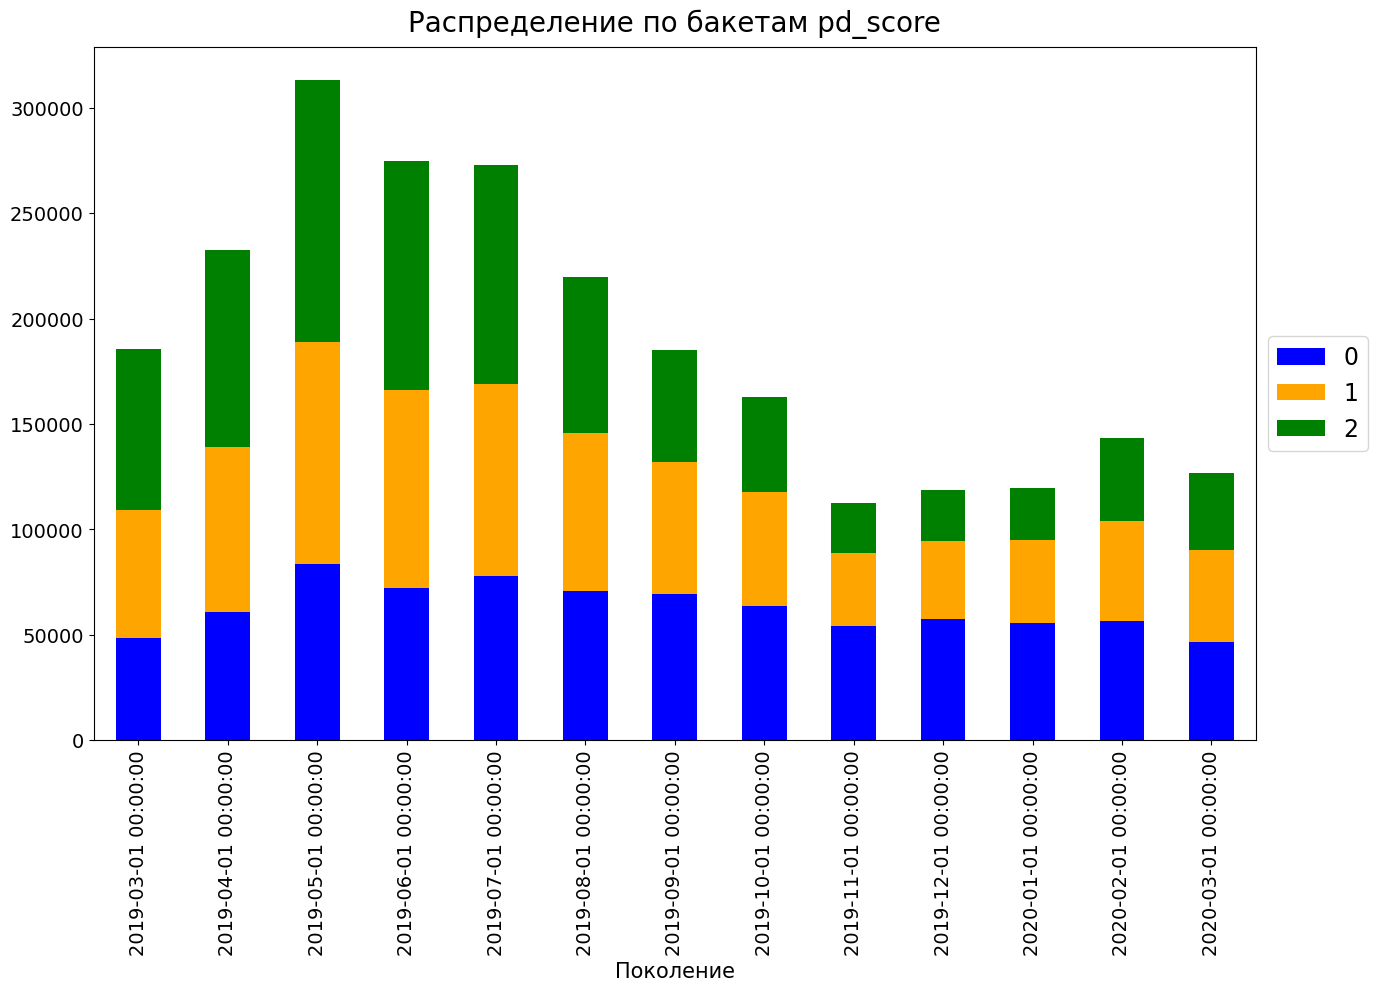

In [52]:
plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам pd_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Здесь я тоже оставлю все бакеты.

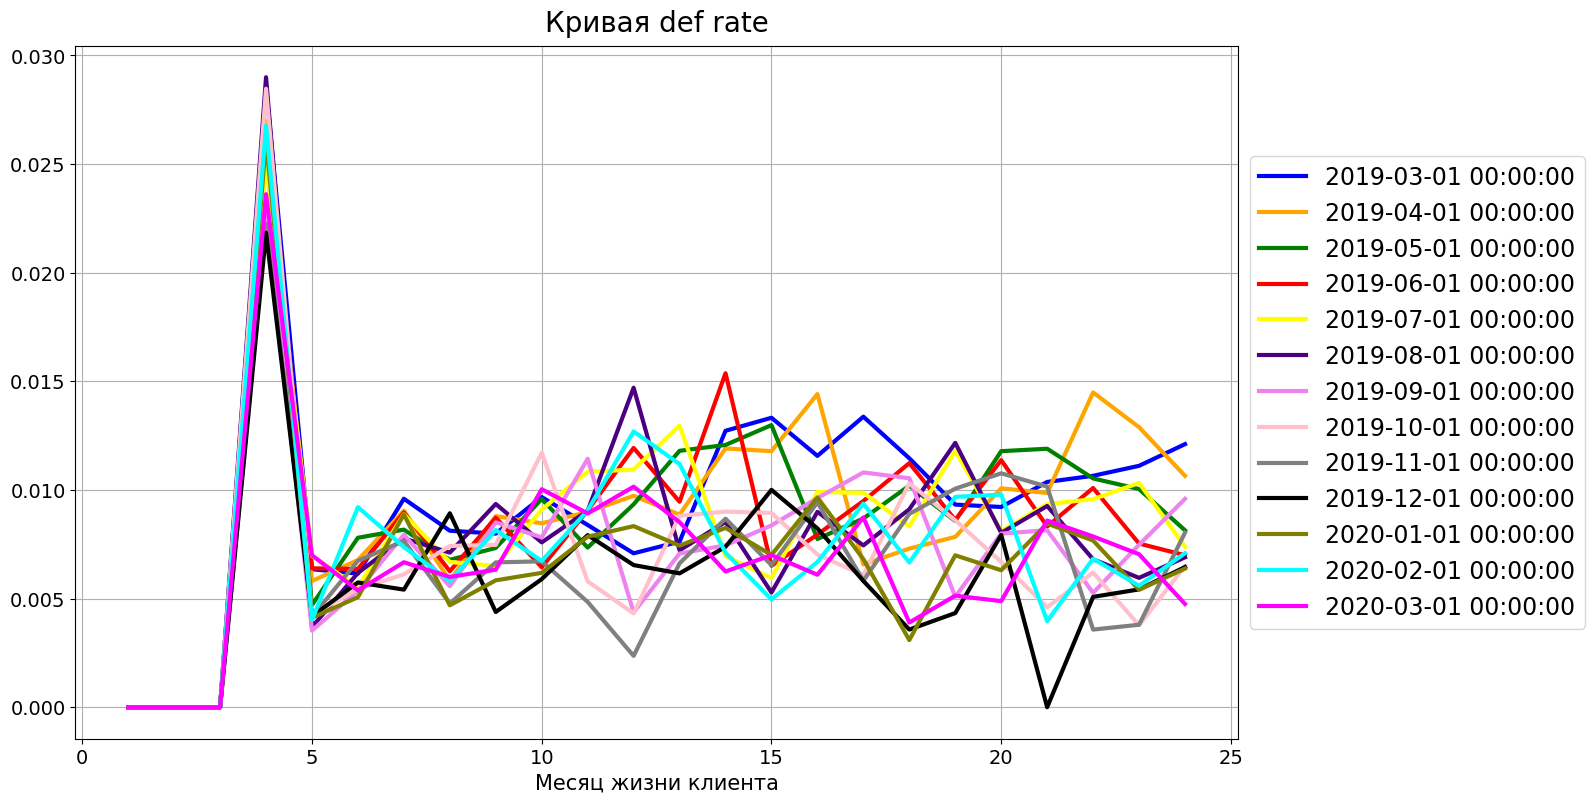

In [53]:
plot_rate_by_generation(df, 'def')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая def rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Виднеется фродовый пик на 4 месяце и несколько пик, похожих скорее на выбросы, чем на правило.

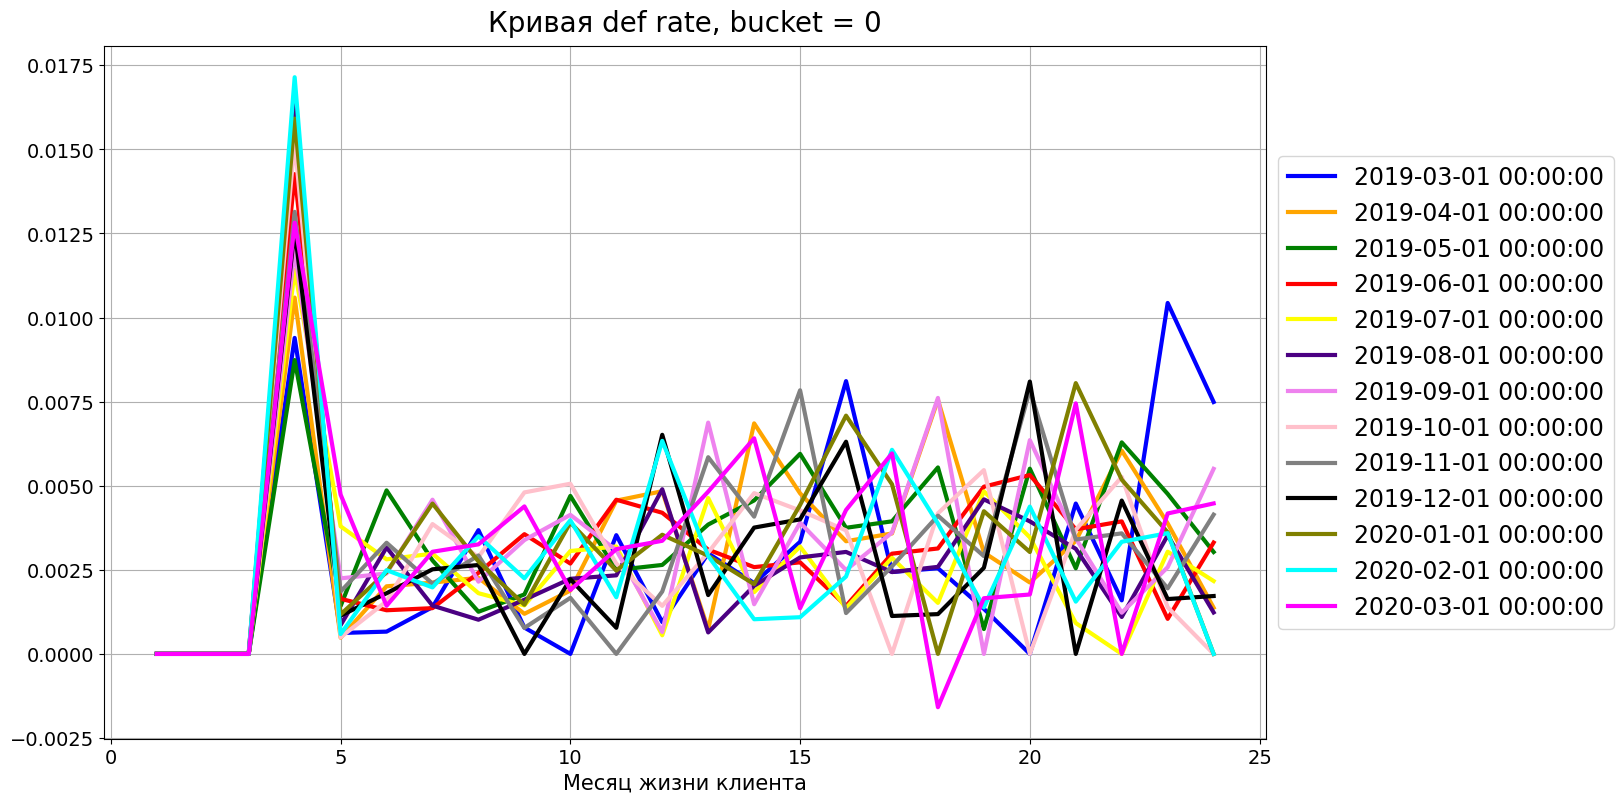

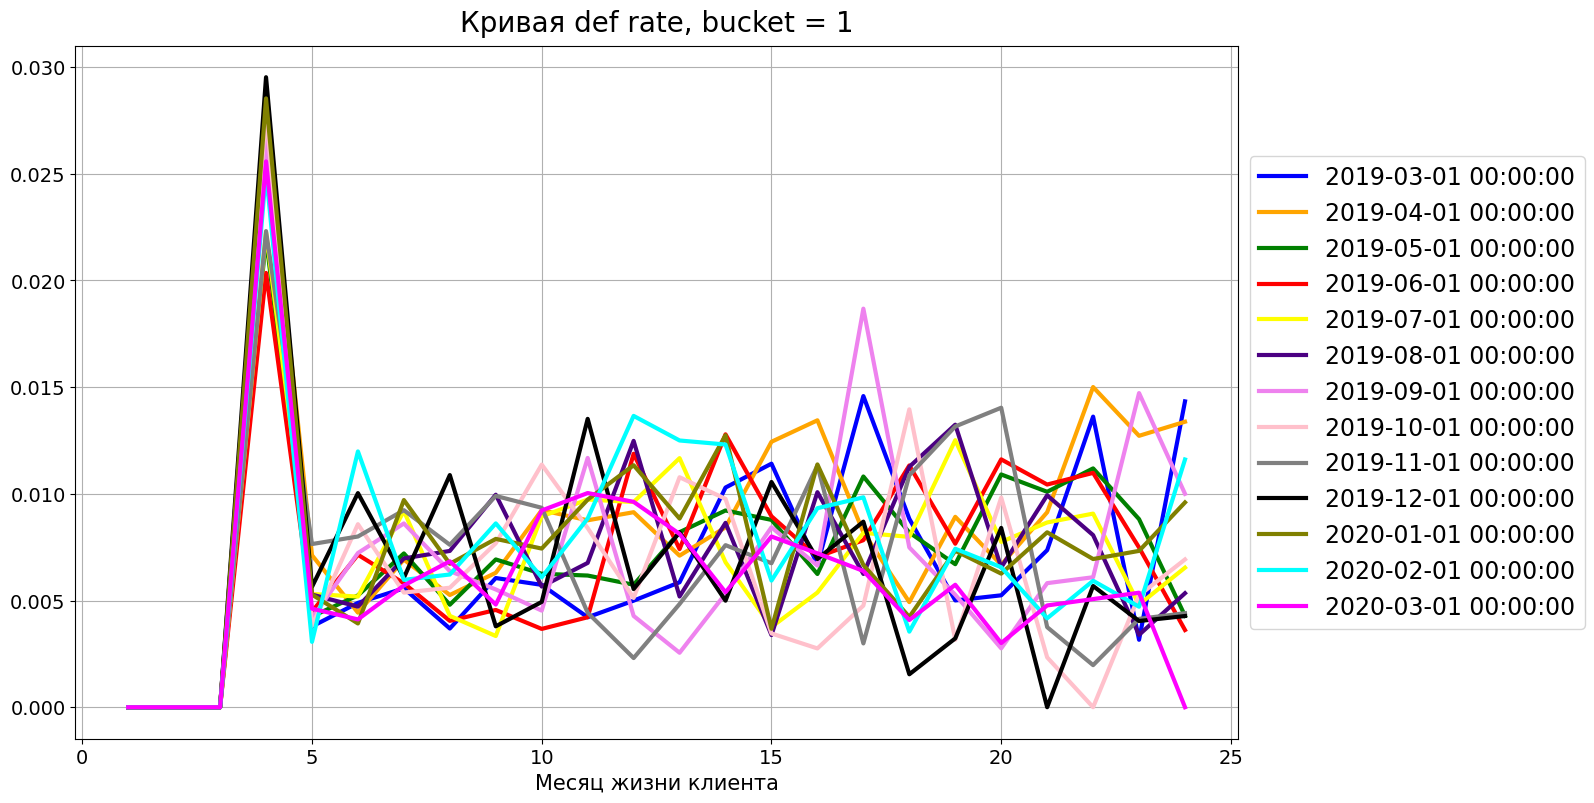

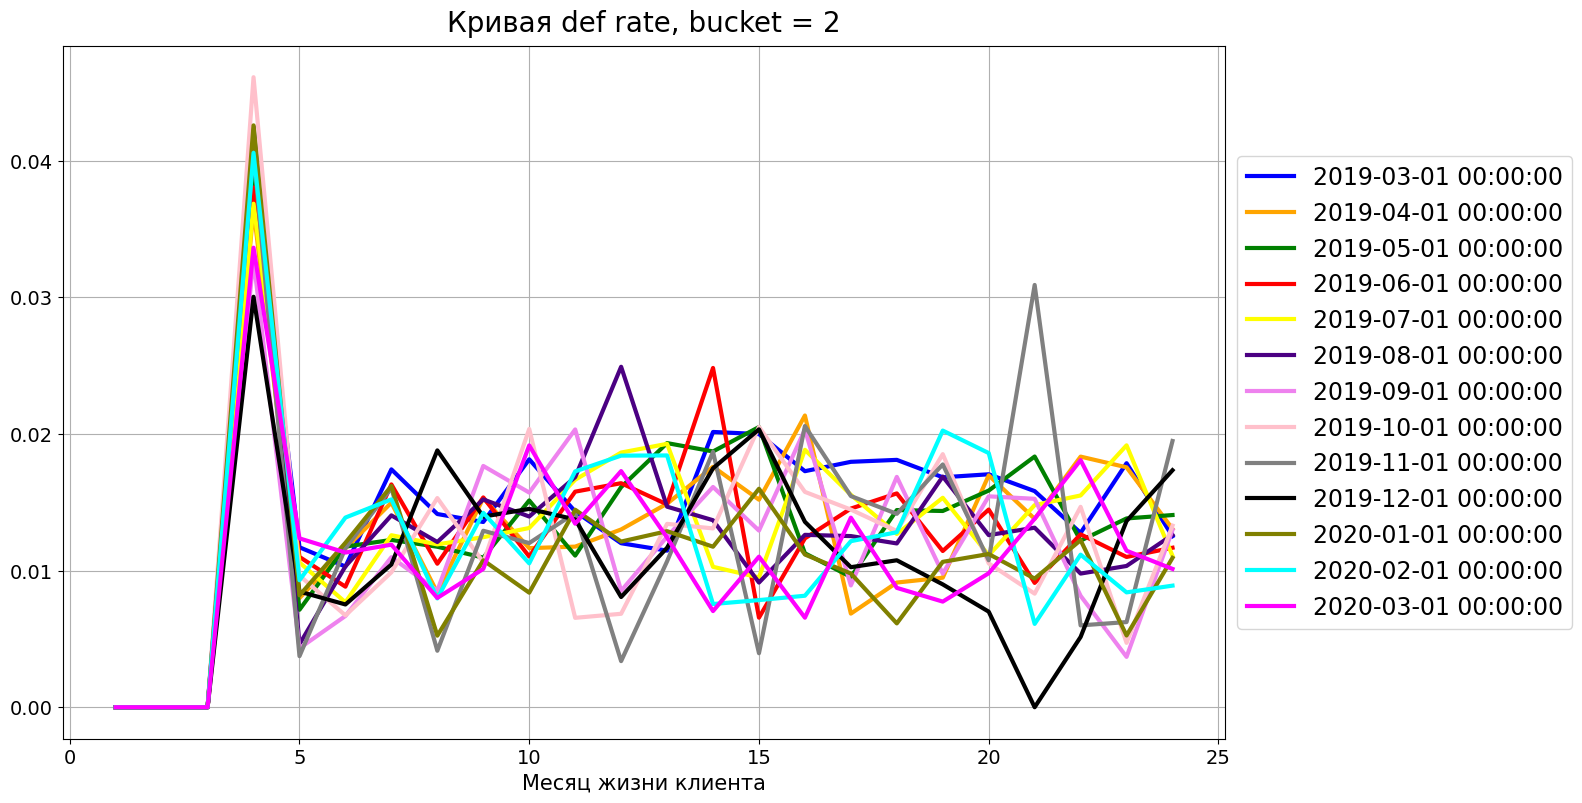

In [54]:
for i in sorted(buckets):
    plot_rate_by_bucket_generation(df, 'pd_bucket', i, 'def')

Видно, что ситуация для разных бакетов повторяется только на 4 месяц. Остальные особые точки - выбросы, обусловленные внешним влиянием.

In [55]:
df_rate = df.groupby(["pd_bucket", "gen_month_dt", "statement_num"], as_index=False)\
        .agg({"def_flg": 'sum', "prev_def_flg": 'sum', "prev_act_flg": 'sum', "user_id": np.count_nonzero})\
        .rename(columns = ({"def_flg": 'def_cnt', "prev_def_flg": 'prev_def_cnt', "prev_act_flg": 'prev_act_cnt', "user_id": 'cnt'}))\
        .eval('def_rate = (def_cnt - prev_def_cnt) / prev_act_cnt', inplace=False)

Nfeval = 0

res = decomposition(df_rate, 
                       generation = 'gen_month_dt', 
                       group = 'pd_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'def_rate')

C:\Users\pc\AppData\Local\Temp\ipykernel_12784\2965199190.py:127: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query['month_dt'] = df_query[generation] + timedelta


pd_bucket = 0
Initial 0.005636
0  0.001567
1  0.001503
2  0.001503
3  0.001502
4  0.001502
5  0.001502
6  0.001502
7  0.001502
8  0.001502
9  0.001502
10  0.001502
11  0.001502
pd_bucket = 1
Initial 0.025083
12  0.005290
13  0.005109
14  0.005104
15  0.005098
16  0.005098
17  0.005098
18  0.005098
19  0.005098
20  0.005098
pd_bucket = 2
Initial 0.066938
21  0.014598
22  0.013826
23  0.013751
24  0.013716
25  0.013700
26  0.013692
27  0.013689
28  0.013687
29  0.013686
30  0.013686
31  0.013686
32  0.013686
33  0.013686
34  0.013686
35  0.013686


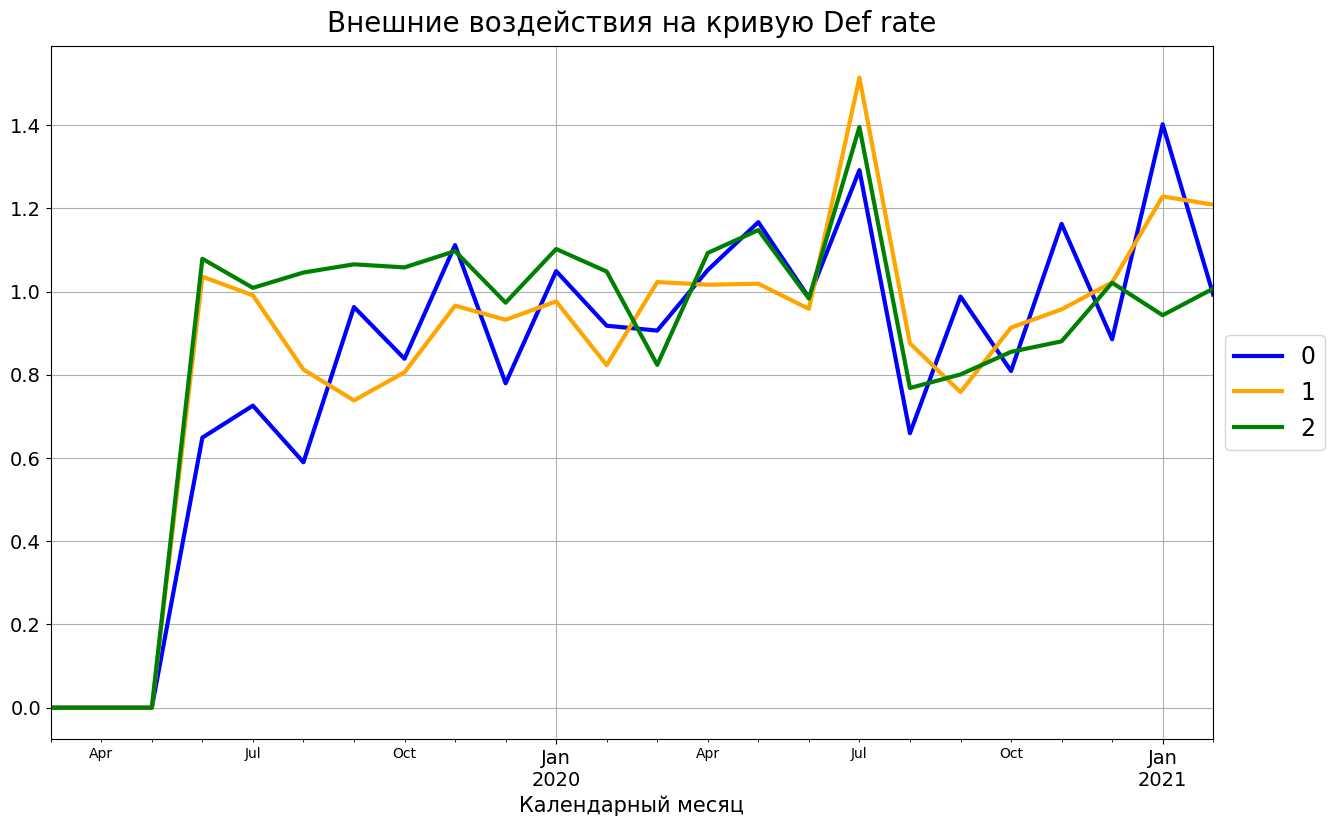

In [56]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Def rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Видно, что в июле что-то повиляло на скачок дефолтов во всех бакетах.
В январе на низких и средних pd тоже наблюдается скачок, скорее всего - выброс.

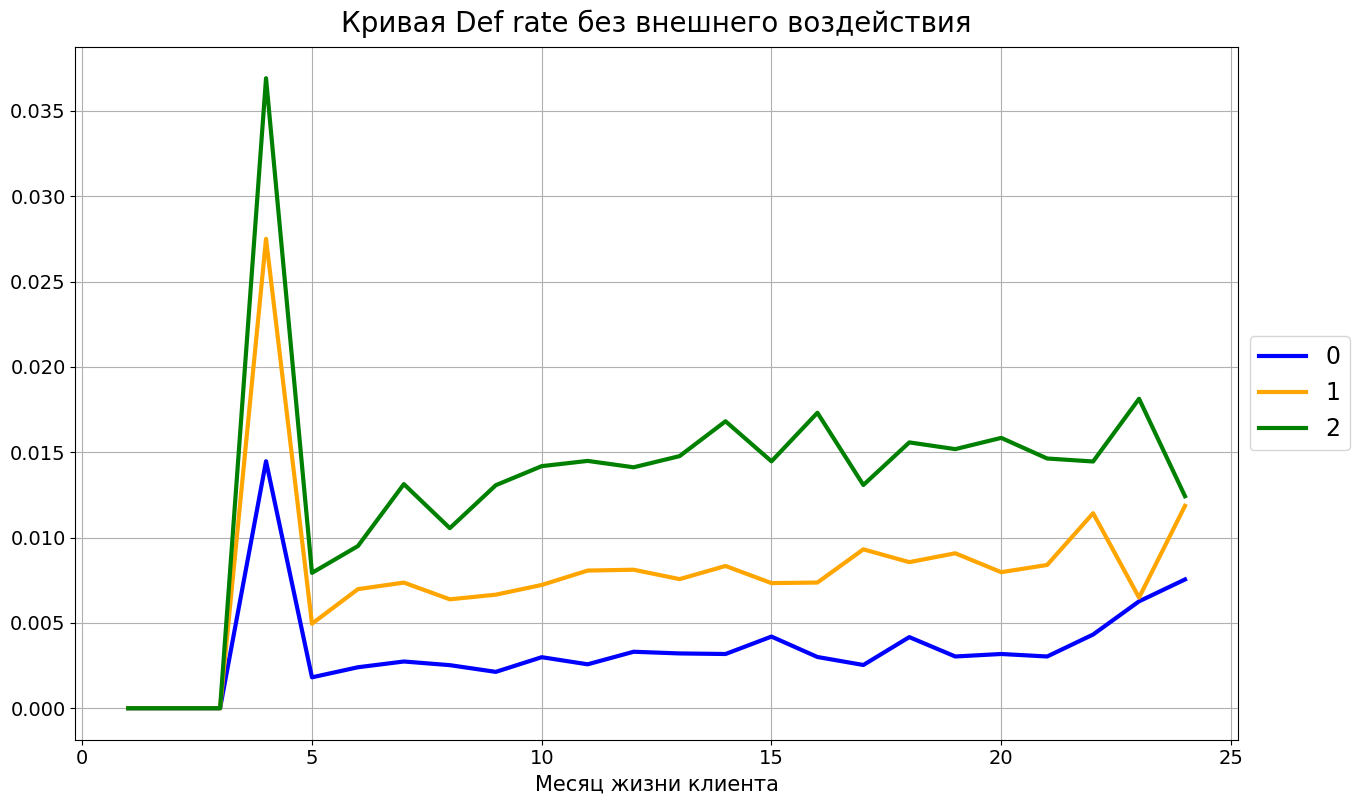

In [57]:
res['maturation_data'].drop(['statement_num'], axis=1).set_axis(range(1, 24+1)).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Def rate без внешнего воздействия", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Здесь подтверждается статистическое наличие фродового пика.

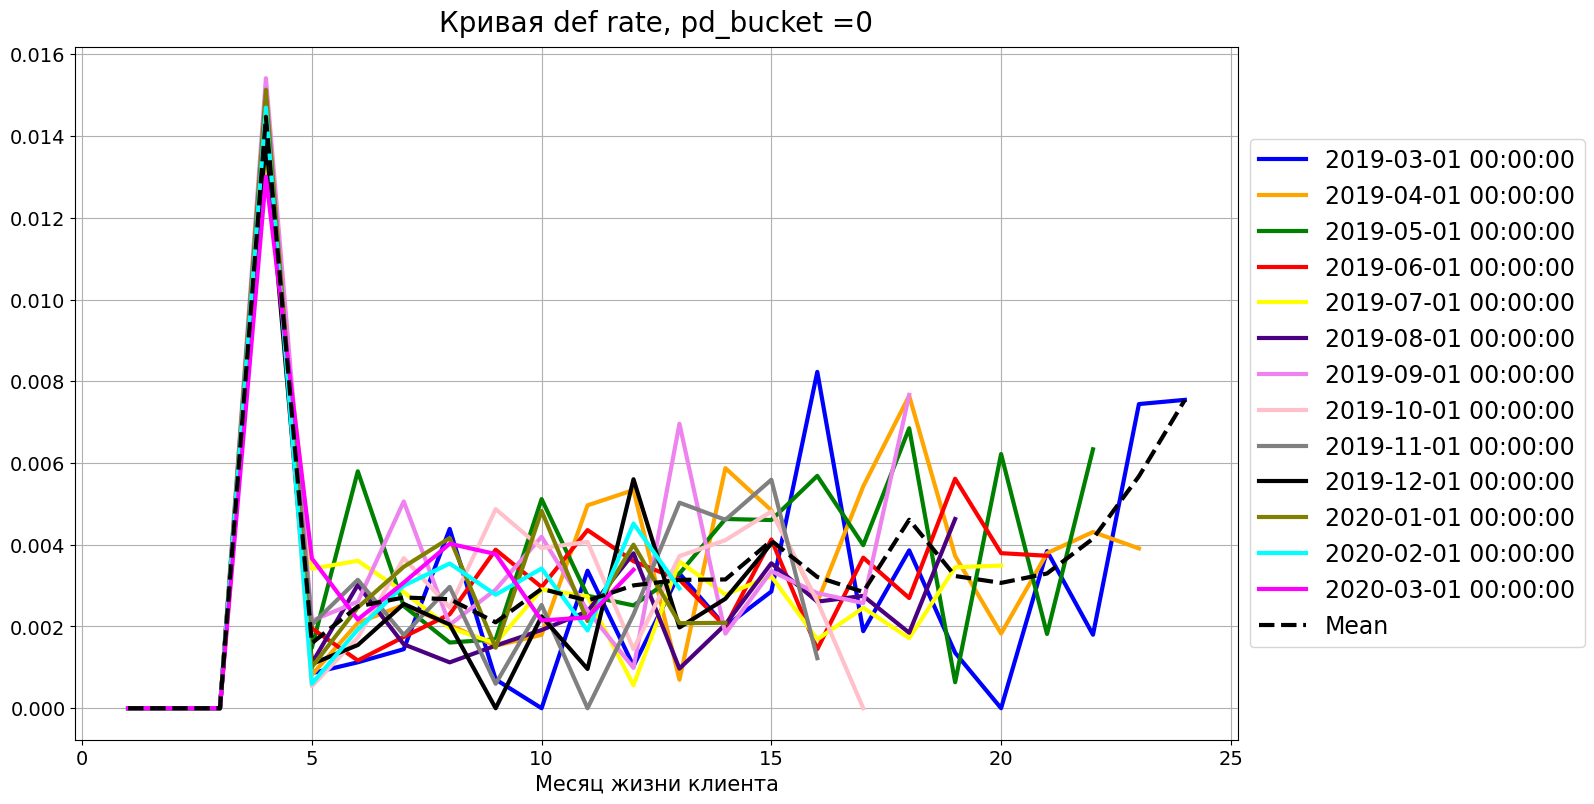

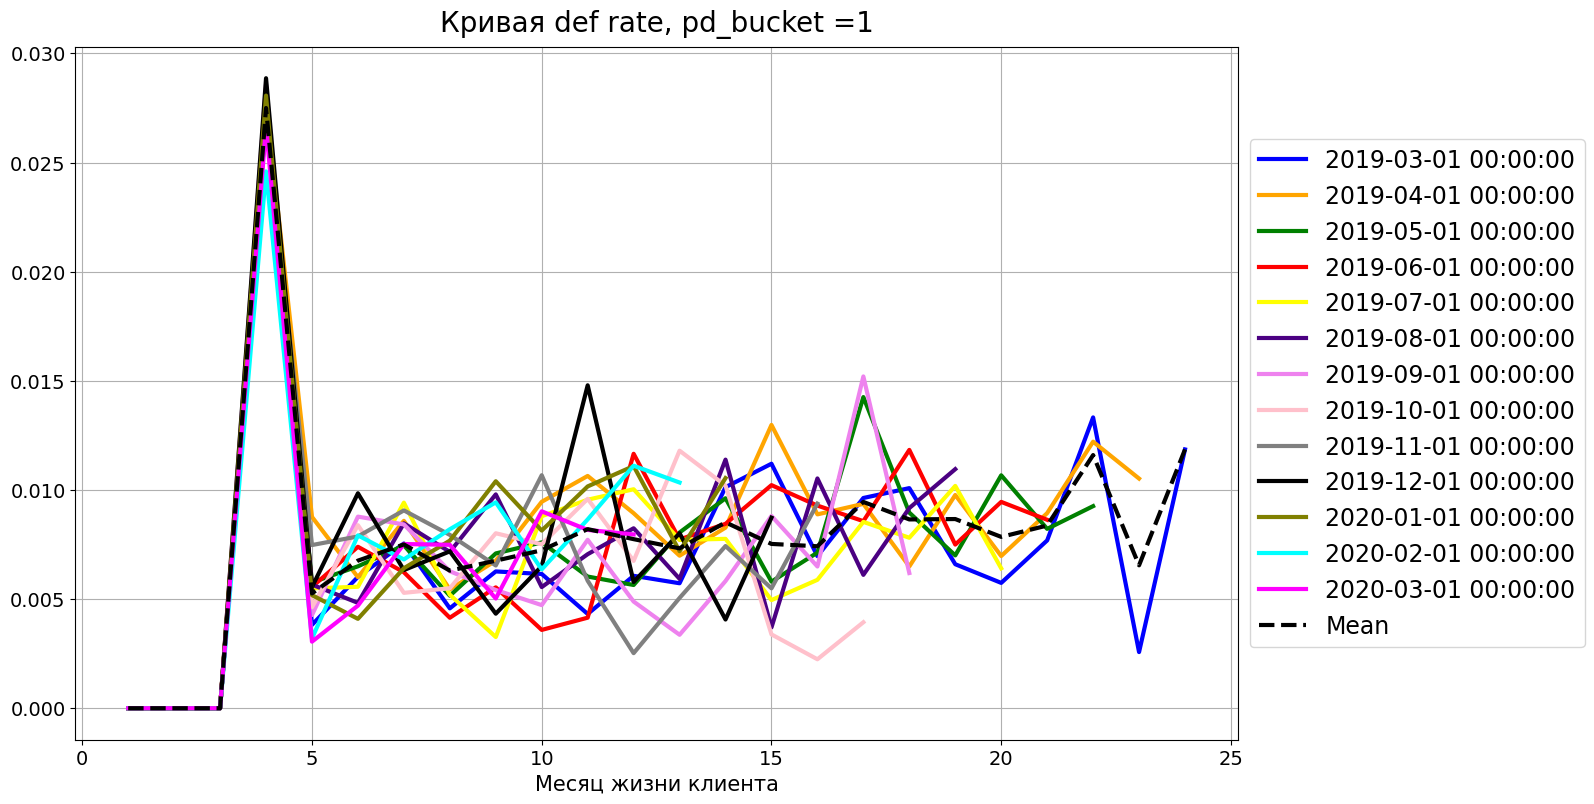

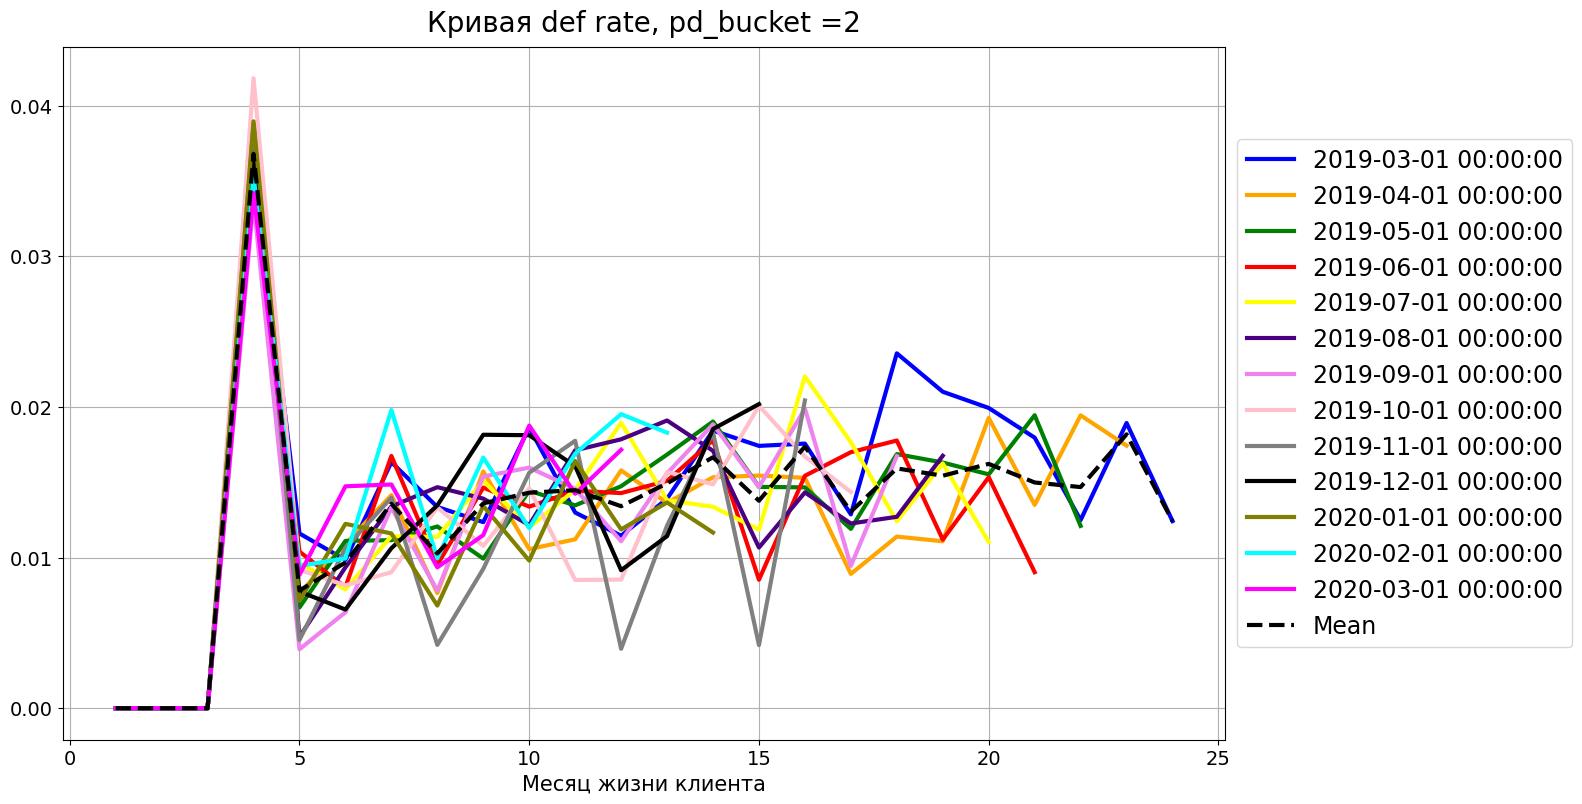

In [58]:
rate_mean = res['fitted_data'].groupby(['pd_bucket', 'statement_num'])\
    .agg({'fitted_feature': 'mean'})\
    .rename(columns = {'fitted_feature': 'Mean'})

buckets = df['pd_bucket'].drop_duplicates()


for i in sorted(buckets):
    plot_rate_mean('pd_bucket', i, 'def')

А теперь попробуем сгладить кривые по бакетам:

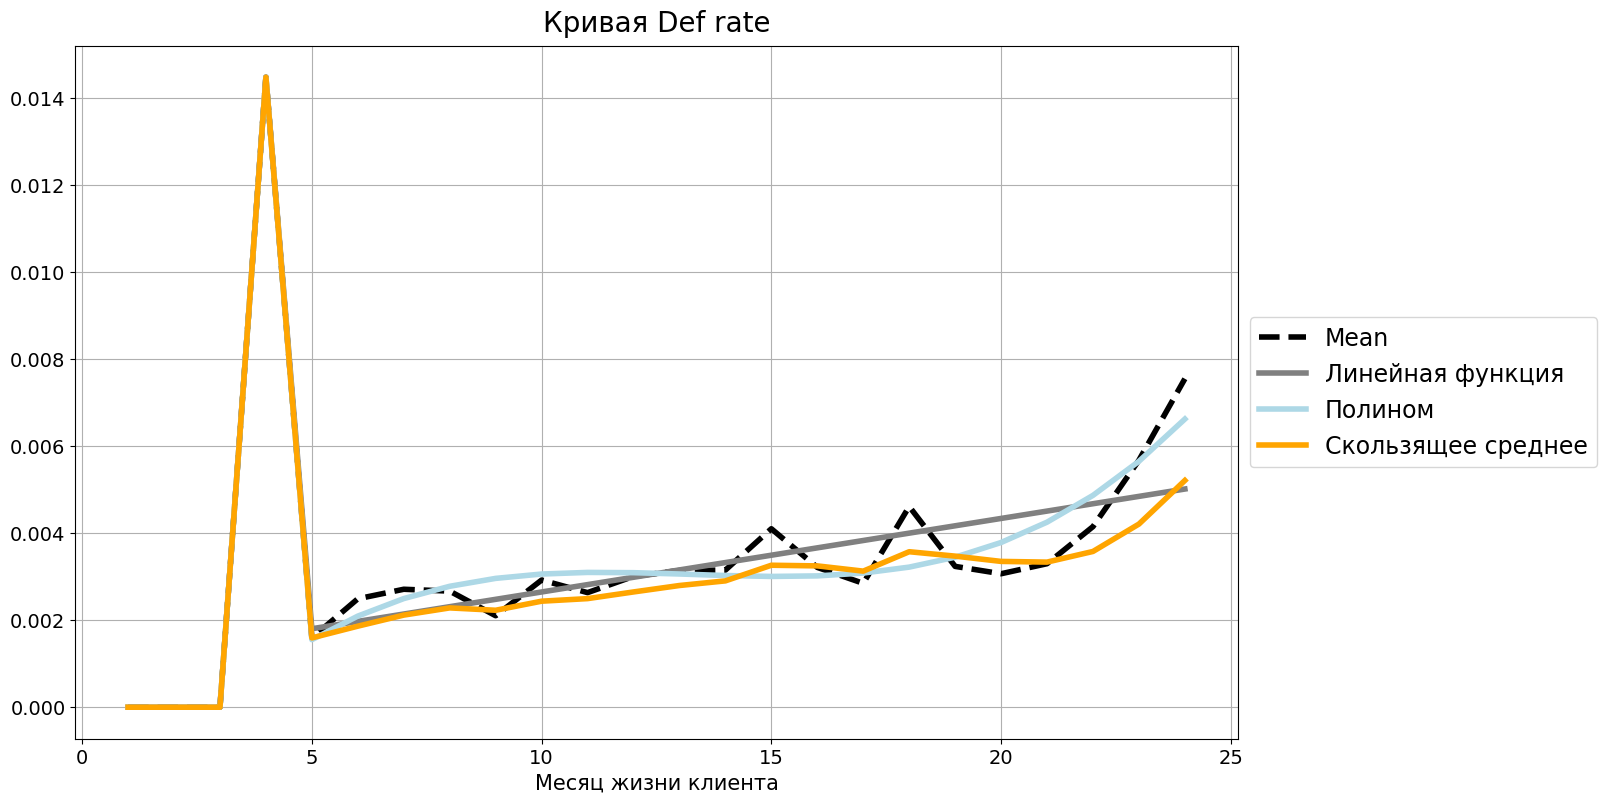

In [59]:
df_linear = rate_mean.query('pd_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 24)
df_polynom = polynom_approximation(df_linear, 5, 24, 3)
df_smooth = exponential_smoothing(df_polynom, 5, 24, 0.3)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Mean'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Def rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Полином хорошо отработал.

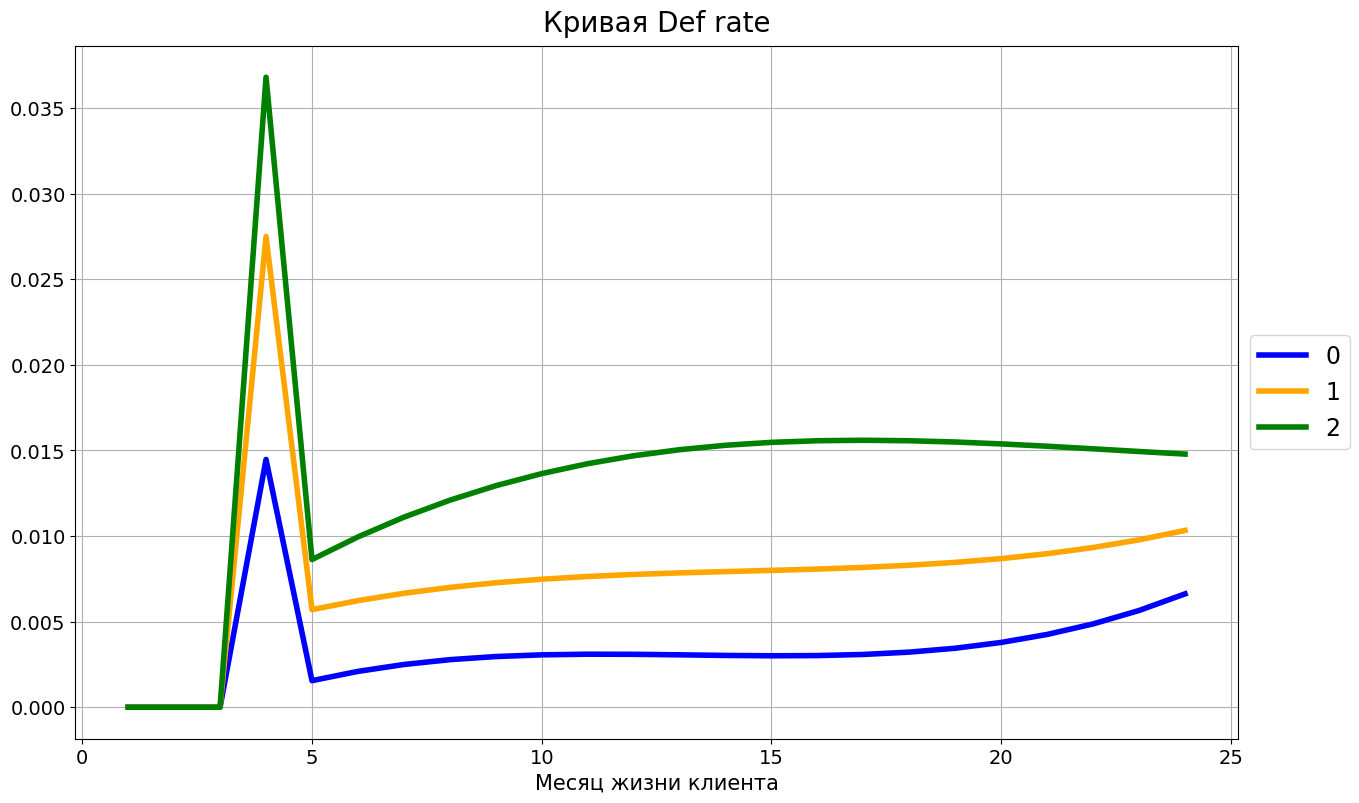

In [60]:
df_linear_0 = rate_mean.query('pd_bucket == 0').reset_index().set_index(['statement_num'])
df_polynom_0 = polynom_approximation(df_linear_0, 5, 24, 3)

df_linear_1 = rate_mean.query('pd_bucket == 1').reset_index().set_index(['statement_num'])
df_polynom_1 = polynom_approximation(df_linear_1, 5, 24, 3)

df_linear_2 = rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_polynom_2 = polynom_approximation(df_linear_2, 5, 24, 3)


plt.figure(figsize=(15, 9))
df_polynom_0['Полином'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
df_polynom_1['Полином'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)
df_polynom_2['Полином'].plot(grid=True, color = 'Green', linestyle = '-', lw = 4)


plt.legend(range(3), loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Def rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [62]:
df_smooth_result = pd.DataFrame(df_polynom_0['Полином']).rename({'Полином': 'pd = 0.011040'}, axis='columns')
df_smooth_result['pd = 0.032685'] = df_polynom_1['Полином']
df_smooth_result['pd = 0.068209'] = df_polynom_2['Полином']

In [65]:
df_smooth_result.to_csv('data/def_rate.csv')